# Skeleton notebook for subject-level and group-level statistics
Use this notebook to write the code for subject- and group-level statistics on EEG data

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne

In [2]:
# defining the events
event_id = {
    'Experiment/Start ': 1,
    #'Baseline/End' : 2, 
    #'Experiment/End': 3,
    'Question/Shows': 4, 
    #'surprise': 40,
    #'normal':41
    'Question/Disappears': 5, 
    'Disappears': 10, 
    'Disappears/NearCorner': 11, 
    'Normal/Reappears': 200, 
    'Normal/Reappears/NearCorner': 201,
    'Surprise/Reappears': 210,
    #'Reappears/Sup/NearCorner': 211,
    'FinalDisappear': 98,
    'CornerHit': 99, 
}

## Loading data

# Group Level

In [3]:
# defining the events
event_id = {
    'Experiment/Start ': 1,
    #'Baseline/End' : 2, 
    #'Experiment/End': 3,
    'Question/Shows': 4, 
    #'Correct': 40,
    #'Incorrect':41
    'Question/Disappears': 5, 
    'Disappears': 10, 
    'Disappears/NearCorner': 11, 
    'Normal/Reappears': 200, 
    'Normal/Reappears/NearCorner': 201,
    'Surprise/Reappears': 210,
    #'Reappears/Sup/NearCorner': 211,
    'FinalDisappear': 98,
    'CornerHit': 99, 
}

In [4]:
def preprocess_EEG_data(raw, bad_channels:list[str], event_id, tmin = -0.2, tmax = 0.5, baseline = (-0.2, 0), l_freq = 0.1, h_freq = 40.0, reject = {"eeg": 150e-6}):

    raw.info["bads"] = bad_channels


    # setting EOG channels surprisely - different names for the channels on the two different acquistion computers
    try:
        raw.set_channel_types({"HEOG": "eog", "VEOG": "eog"})
    
    except(ValueError):
        raw.set_channel_types({"EOG1": "eog", "EOG2": "eog"})

    raw.set_montage("standard_1020")

    

    # interpolate the bad channels 
    # YOU COULD ALSO FIND THE COMMON GOOD CHANNELS WHEN DOING STATS INSTEAD
    # -> BUT WE WILL DO THIS FOR TODAY
    raw.interpolate_bads(reset_bads=True, mode="accurate", verbose=False)

    # dropping the remaining bad channels after interpolation (Fp1 and Fp2)
    raw.drop_channels(raw.info["bads"])

    raw.filter(l_freq, h_freq, verbose=False)
    
    # setting the reference
    raw.set_eeg_reference("average", projection=False, verbose = False)

    # creating the events
    events, _ = mne.events_from_annotations(raw, verbose=False)

    # remove events from event id that are not in the data (to avoid errors when creating the epochs)
    event_id_tmp = {key: value for key, value in event_id.items() if value in events[:, 2]}


    # creating the epochs
    epochs_tmp = mne.Epochs(
        raw, 
        events, 
        event_id=event_id_tmp,
        tmin=tmin, 
        tmax=tmax, 
        baseline=baseline, 
        preload=True, 
        reject=reject,
        verbose = False
    )

    # downsample the epochs
    epochs_tmp = epochs_tmp.resample(250)

    return epochs_tmp

In [5]:
# load in the data
data_path = Path("/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/EEGDataOwnFRFR") # insert path to the preprocessed epochs of the FaceWord EEG data


# loading in the file with the bad channels identified by each group
session_info_path = data_path / "session_info.txt"

    
# load in session information (bad channels, etc.) txt file with dictionary
with open(session_info_path, "r") as f:
    session_info = eval(f.read())

print(session_info)

# creating a figures folder for saving plots from drop log
fig_path = Path("/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/figures")

if not fig_path.exists():
    fig_path.mkdir(parents=True)

{'group4_own': {'bad_channels': ['TP9', 'TP10'], 'tmin': -0.2, 'tmax': 0.5}, 'group4_own_2': {'bad_channels': ['T7'], 'tmin': 0.2, 'tmax': 0.5}}



Processing participant1...
Bad channels: ['TP10', 'TP9']


Extracting parameters from /work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/EEGDataOwnFRFR/group4_own.vhdr...
Setting channel info structure...
Reading 0 ... 945759  =      0.000 ...   945.759 secs...


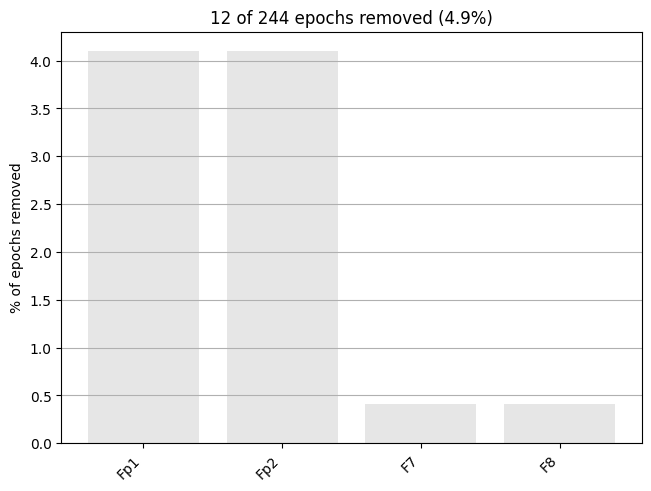

Finished participant1

Processing participant2...
Bad channels: ['T7']
Extracting parameters from /work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/EEGDataOwnFRFR/group4_own_2.vhdr...
Setting channel info structure...
Reading 0 ... 1071459  =      0.000 ...  1071.459 secs...


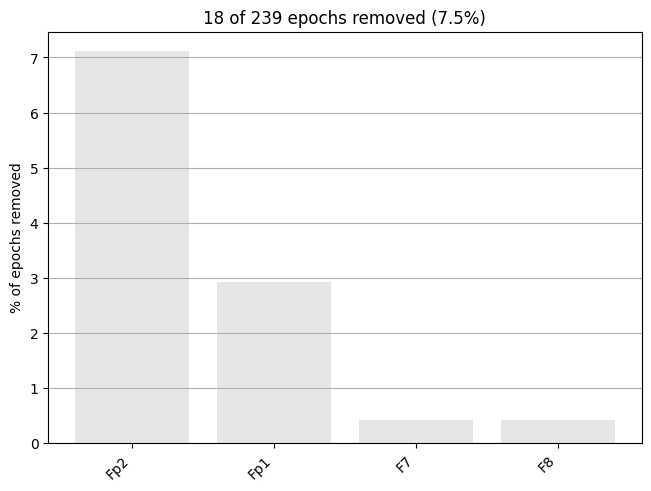

Finished participant2


In [6]:
groupname = "group4_own"  # Base name (without _2)

# Manually define session_info since you only have 2 participants
session_info = {
    "participant1": {
        "bad_channels": ["TP10", "TP9"],  # Update with actual bad channels for 1st participant
        "tmin": None,  # Set crop start time if needed (else None)
        "tmax": None   # Set crop end time if needed (else None)
    },
    "participant2": {
        "bad_channels": ["T7"],  # Update with actual bad channels for 2nd participant
        "tmin": None,
        "tmax": None
    }
}

# Initialize list to store epochs
all_epochs = []

# Loop over participants
for participant, info in session_info.items():
    print(f"\nProcessing {participant}...")
    print(f"Bad channels: {info['bad_channels']}")

    # Load the surprise file (group4_own.vhdr or group4_own_2.vhdr)
    if participant == "participant1":
        vhdr_file = data_path / f"{groupname}.vhdr"  # group4_own.vhdr
    else:
        vhdr_file = data_path / f"{groupname}_2.vhdr"  # group4_own_2.vhdr

    # Load raw data
    raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

    # Crop if needed
    if info["tmin"] is not None or info["tmax"] is not None:
        raw.crop(tmin=info["tmin"], tmax=info["tmax"])

    # Preprocess and epoch
    preprocessed_epochs = preprocess_EEG_data(
        raw,
        bad_channels=info["bad_channels"],
        event_id=event_id  # Ensure event_id is defined elsewhere
    )

    # Save drop log figure
    drop_log_fig = preprocessed_epochs.plot_drop_log()
    drop_log_fig.savefig(fig_path / f"{participant}_drop_log.png")

    # Append to list
    all_epochs.append(preprocessed_epochs)

    print(f"Finished {participant}")

## Group Window N2B-PBa

In [14]:
picks_np = ['Fz', 'FC1', 'FC2', 'Cz', 'CP1', 'CP2']
tmin = 0.2
tmax = 0.4

In [56]:
# code for group-level windowed mean
# prep data for plotting
normal = np.array([])
surprise = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_normal = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]

    # extract the data for the time window and channels of interest
    data_normal = epochs_normal.get_data(picks = picks_np, tmin = tmin, tmax = tmax)
    data_surprise = epochs_surprise.get_data(picks = picks_np, tmin = tmin, tmax = tmax)

    # calculate the mean over the channel and trial dimension (axis 1 and 2)
    # we keep the time dimension (axis 0) to plot the time course
    data_normal_mean = np.mean(data_normal, axis=(0, 1))
    data_surprise_mean = np.mean(data_surprise, axis=(0, 1))
    print(data_normal_mean.shape)

    # append the data to the arrays
    normal = np.concatenate((normal, data_normal_mean), axis=0)
    surprise = np.concatenate((surprise, data_surprise_mean), axis=0)

print(normal.shape)
print(surprise.shape)

# Average over trials & channels (keep time dimension)
normal_mean = np.mean(data_normal, axis=(0, 1))  # shape: [n_timepoints]
surprise_mean = np.mean(data_surprise, axis=(0, 1))

print(normal_mean.shape)
print(surprise_mean.shape)


(50,)
(50,)
(100,)
(100,)
(50,)
(50,)


### T test

In [62]:
from scipy import stats

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(normal_mean, surprise_mean)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -14.753430792197326, P-value: 1.2361552462942105e-26


### Plot Averaged

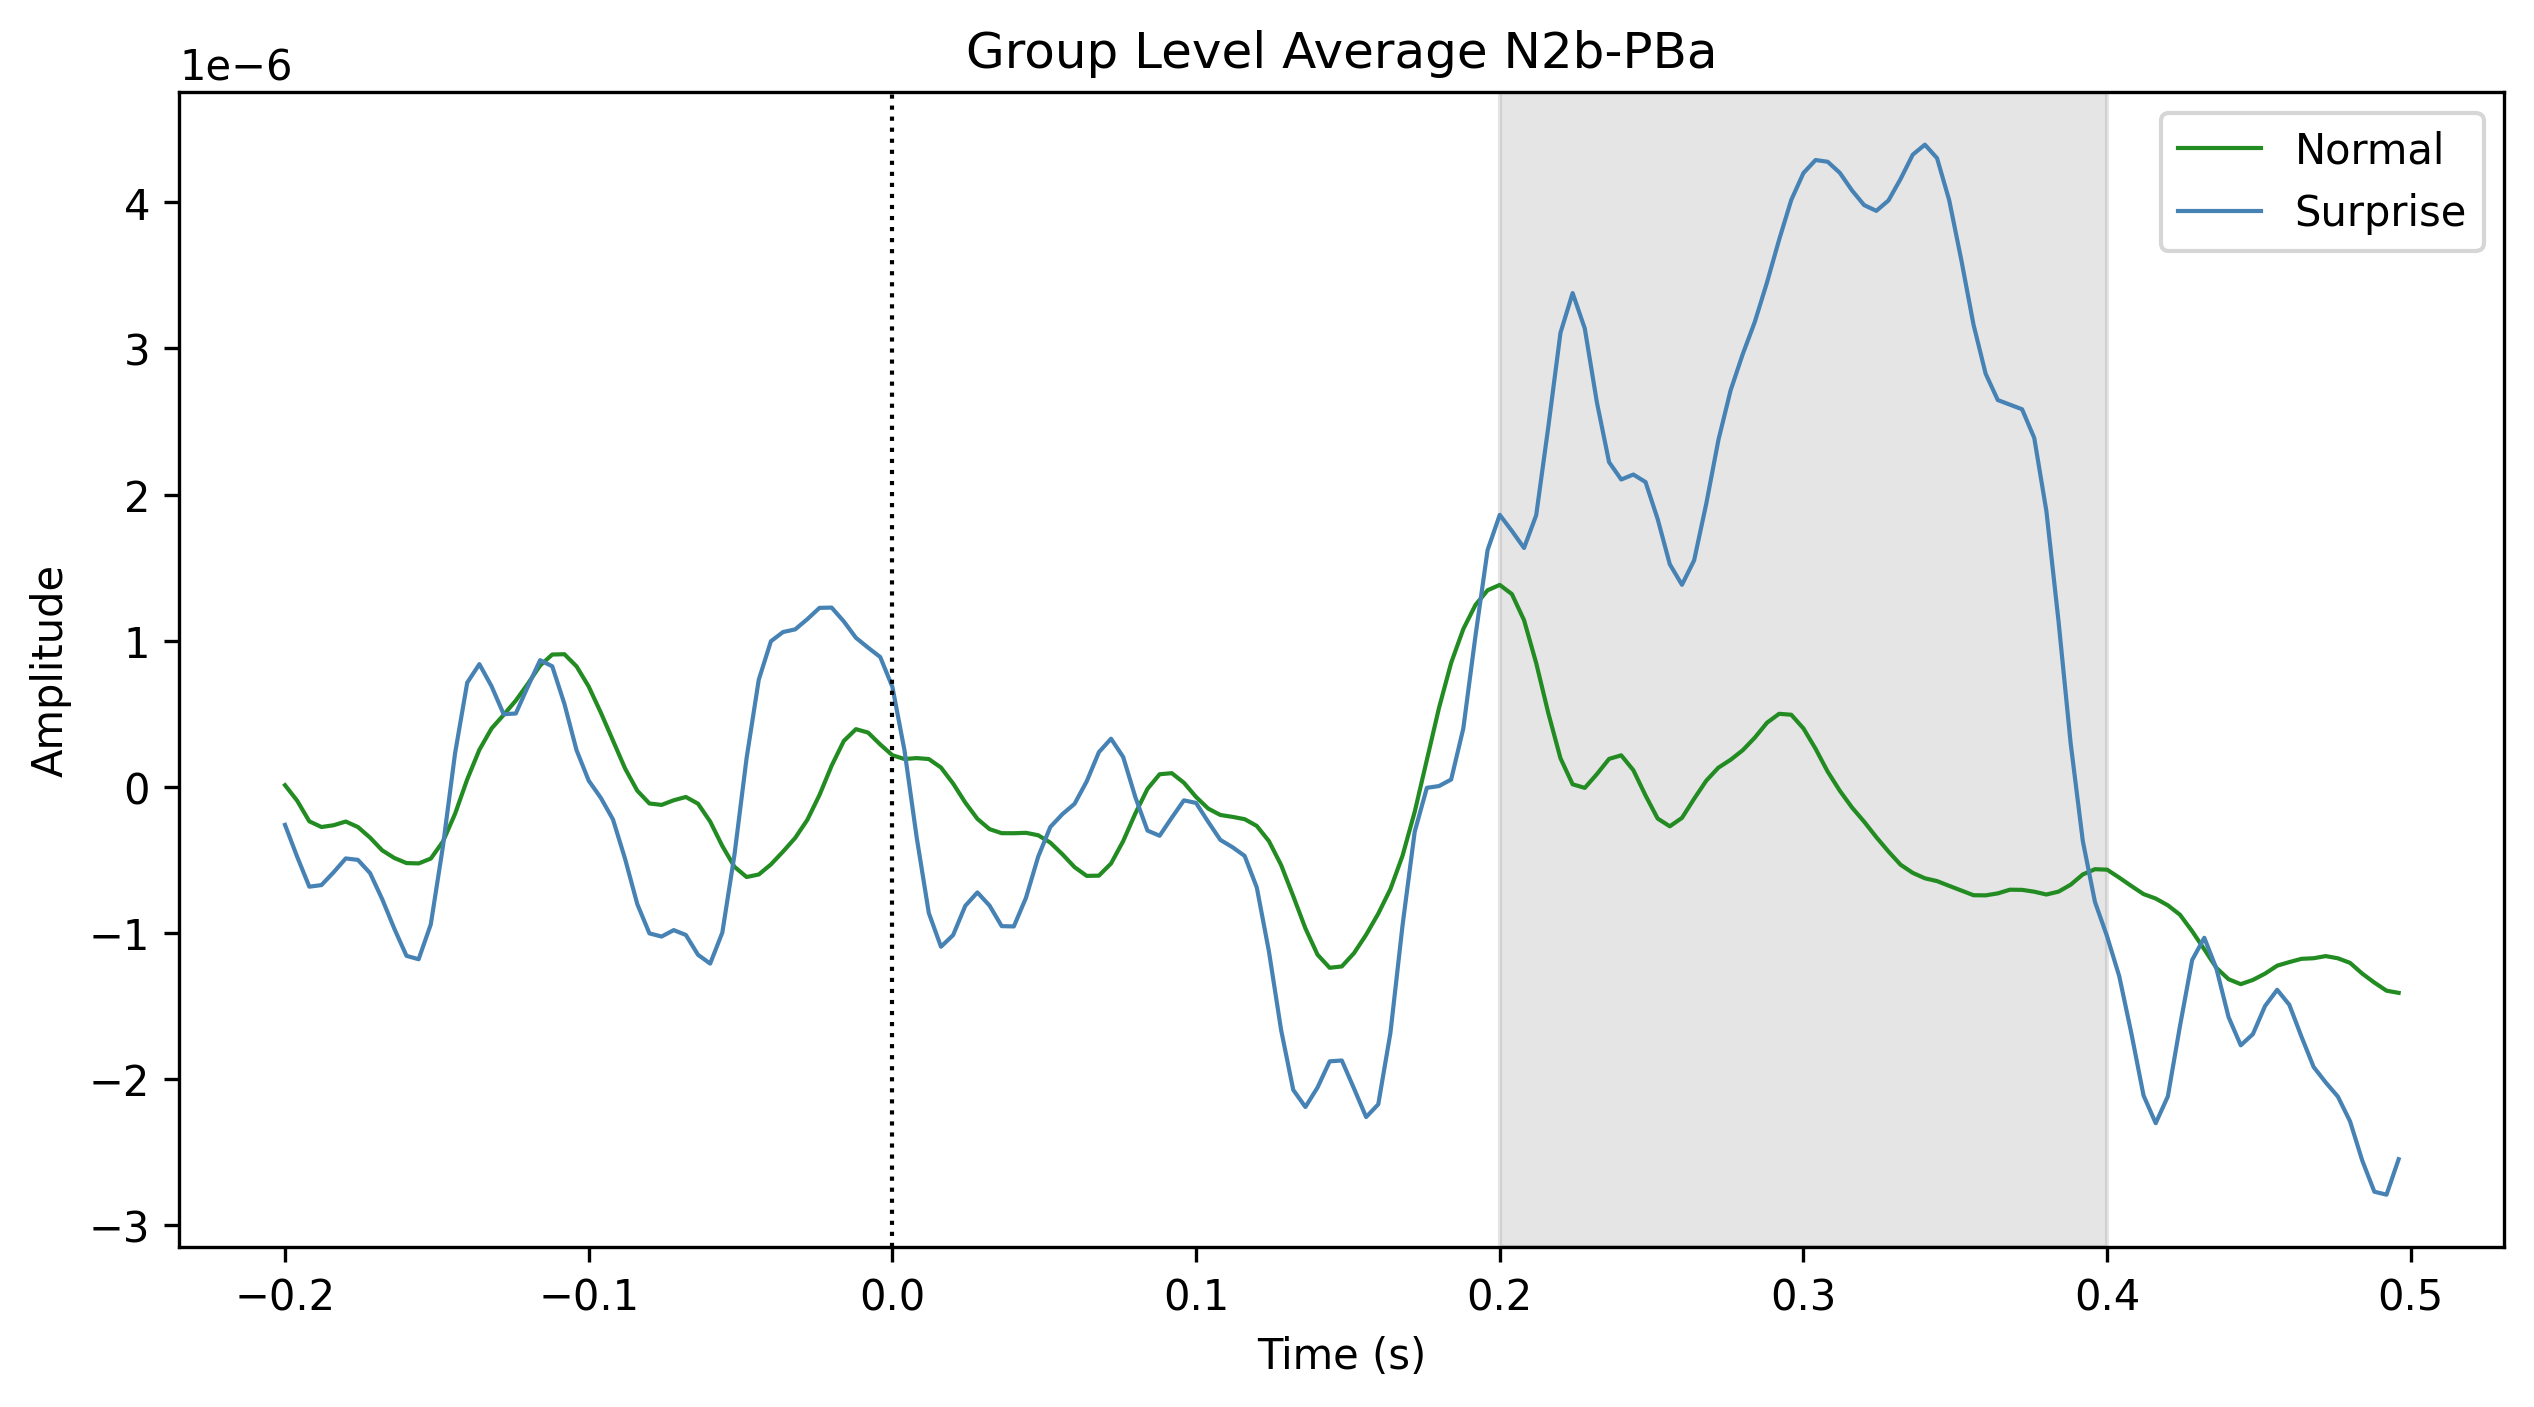

In [15]:
plot_data1 = epochs_normal.get_data(picks=picks_np, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data2 = epochs_surprise.get_data(picks=picks_np, copy = True).mean(axis=(0, 1)) # mean over channels and trials 

# plotting averaged timecourses for each participant
times = epochs_normal.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, plot_data1, label="Normal", color='forestgreen', linestyle="-", linewidth=1)
ax.plot(times, plot_data2, label= "Surprise", color='steelblue', linestyle="-", linewidth=1)

ax.axvline(0, color="black", linestyle=":", linewidth=1)
ax.set(xlabel="Time (s)", ylabel="Amplitude", title="Group Level Average N2b-PBa")
ax.legend(loc = "upper right")

ax.legend()
plt.show()

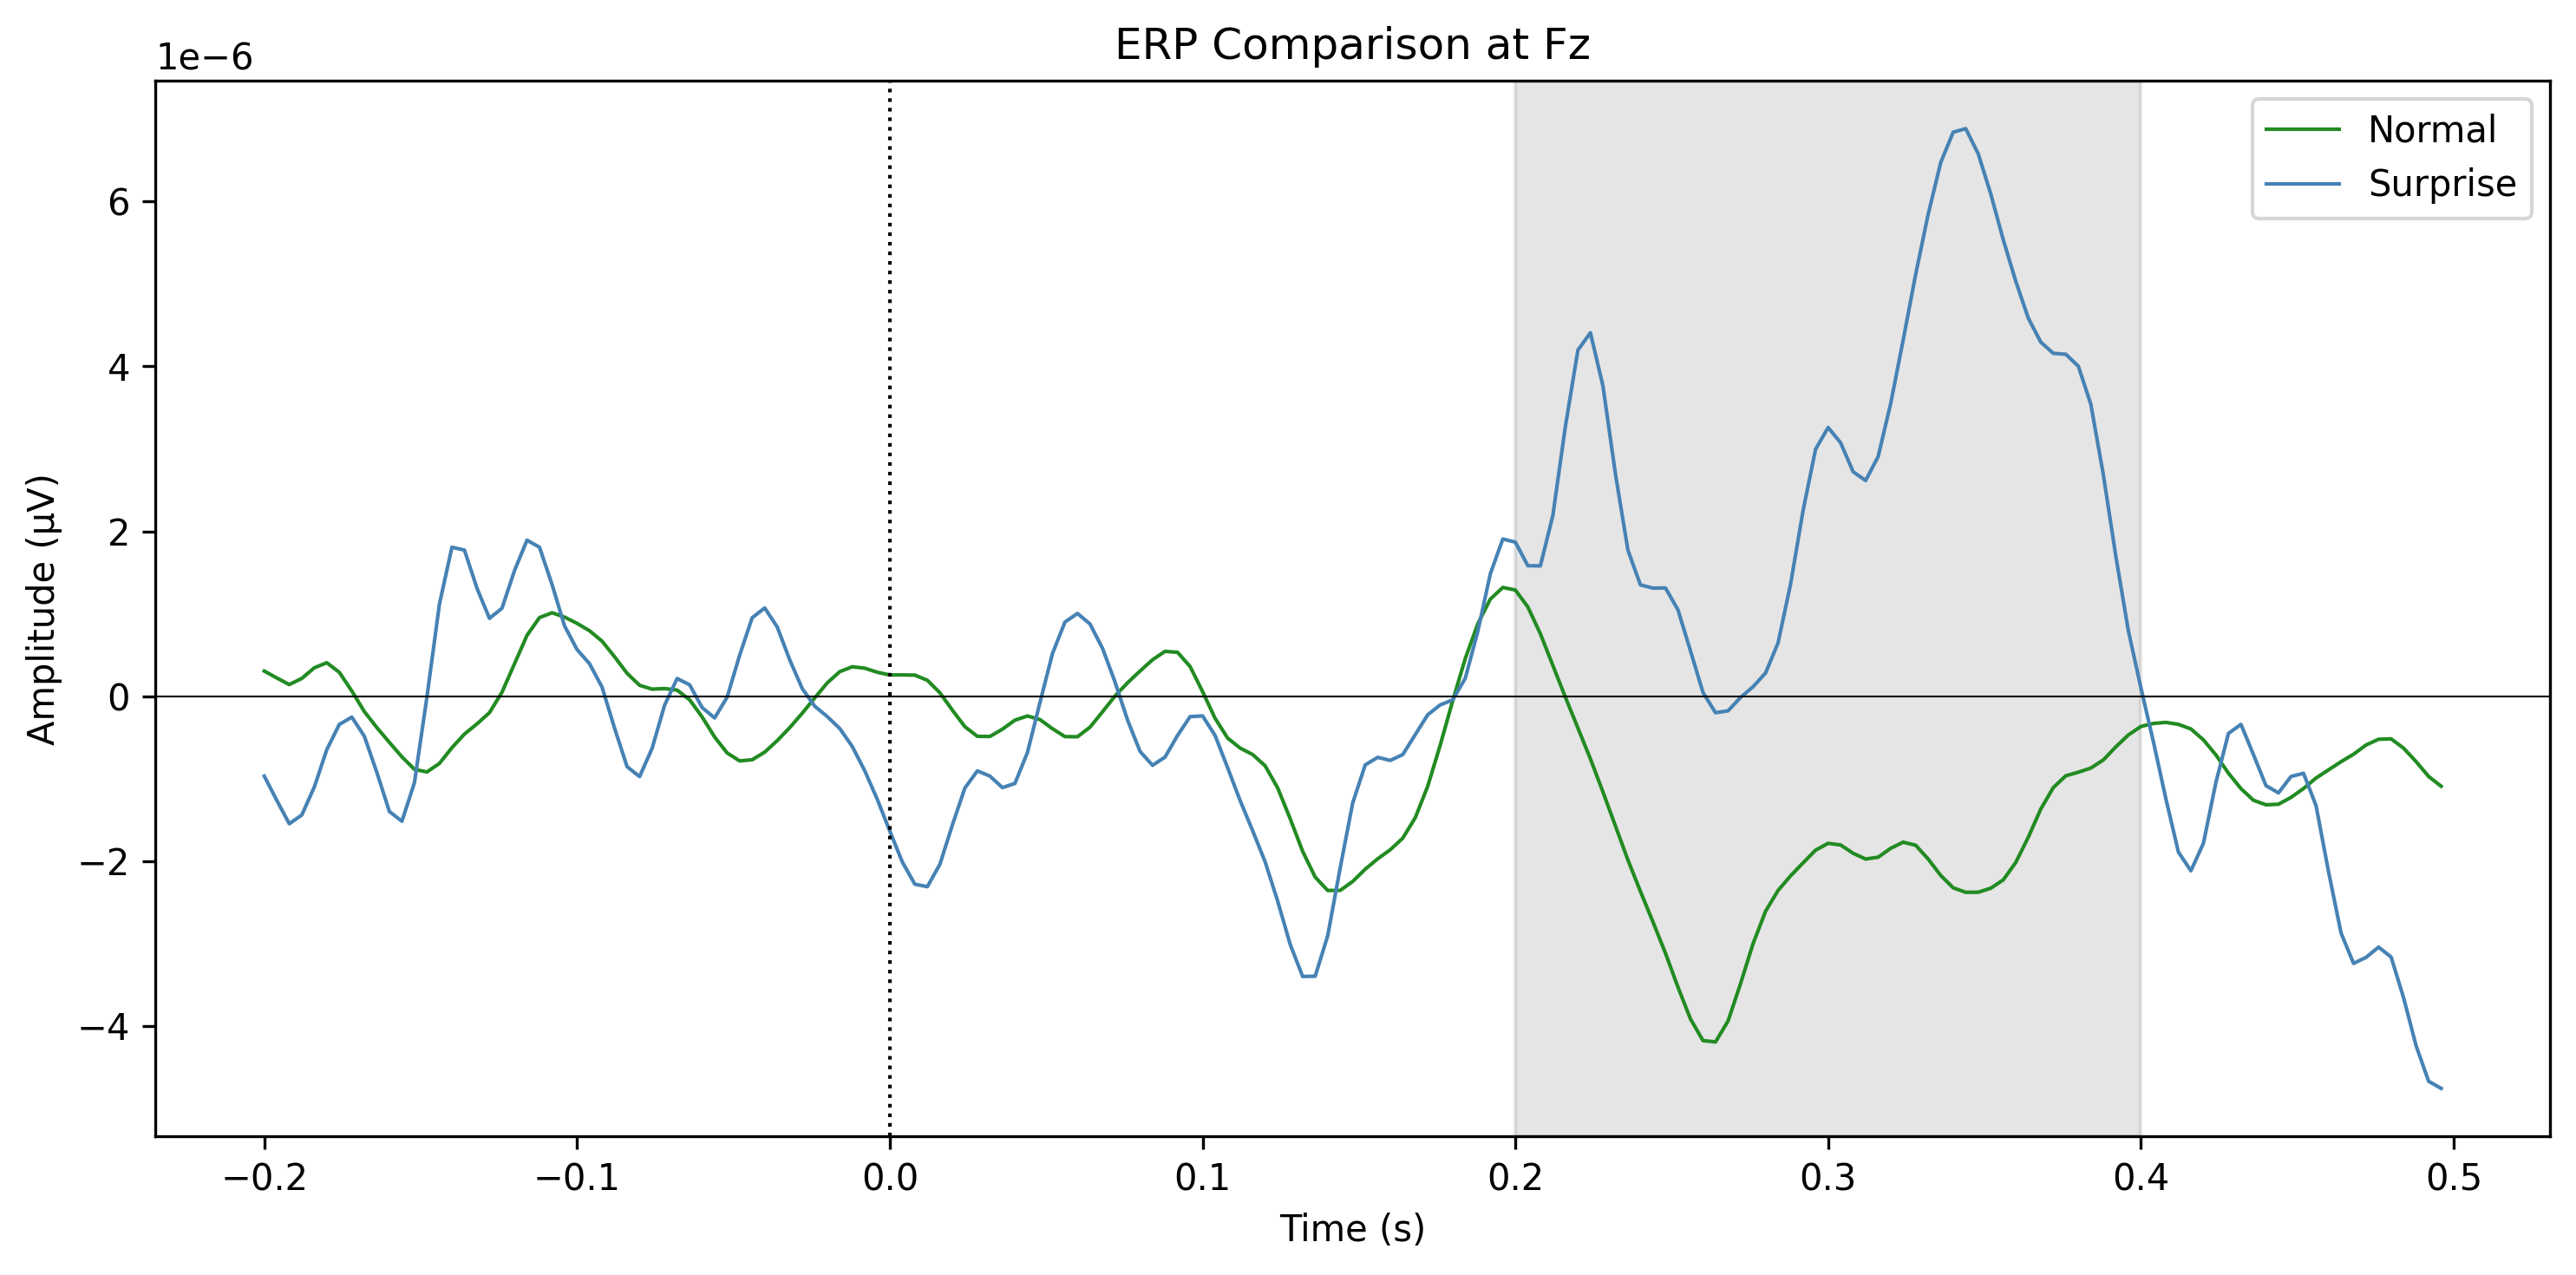

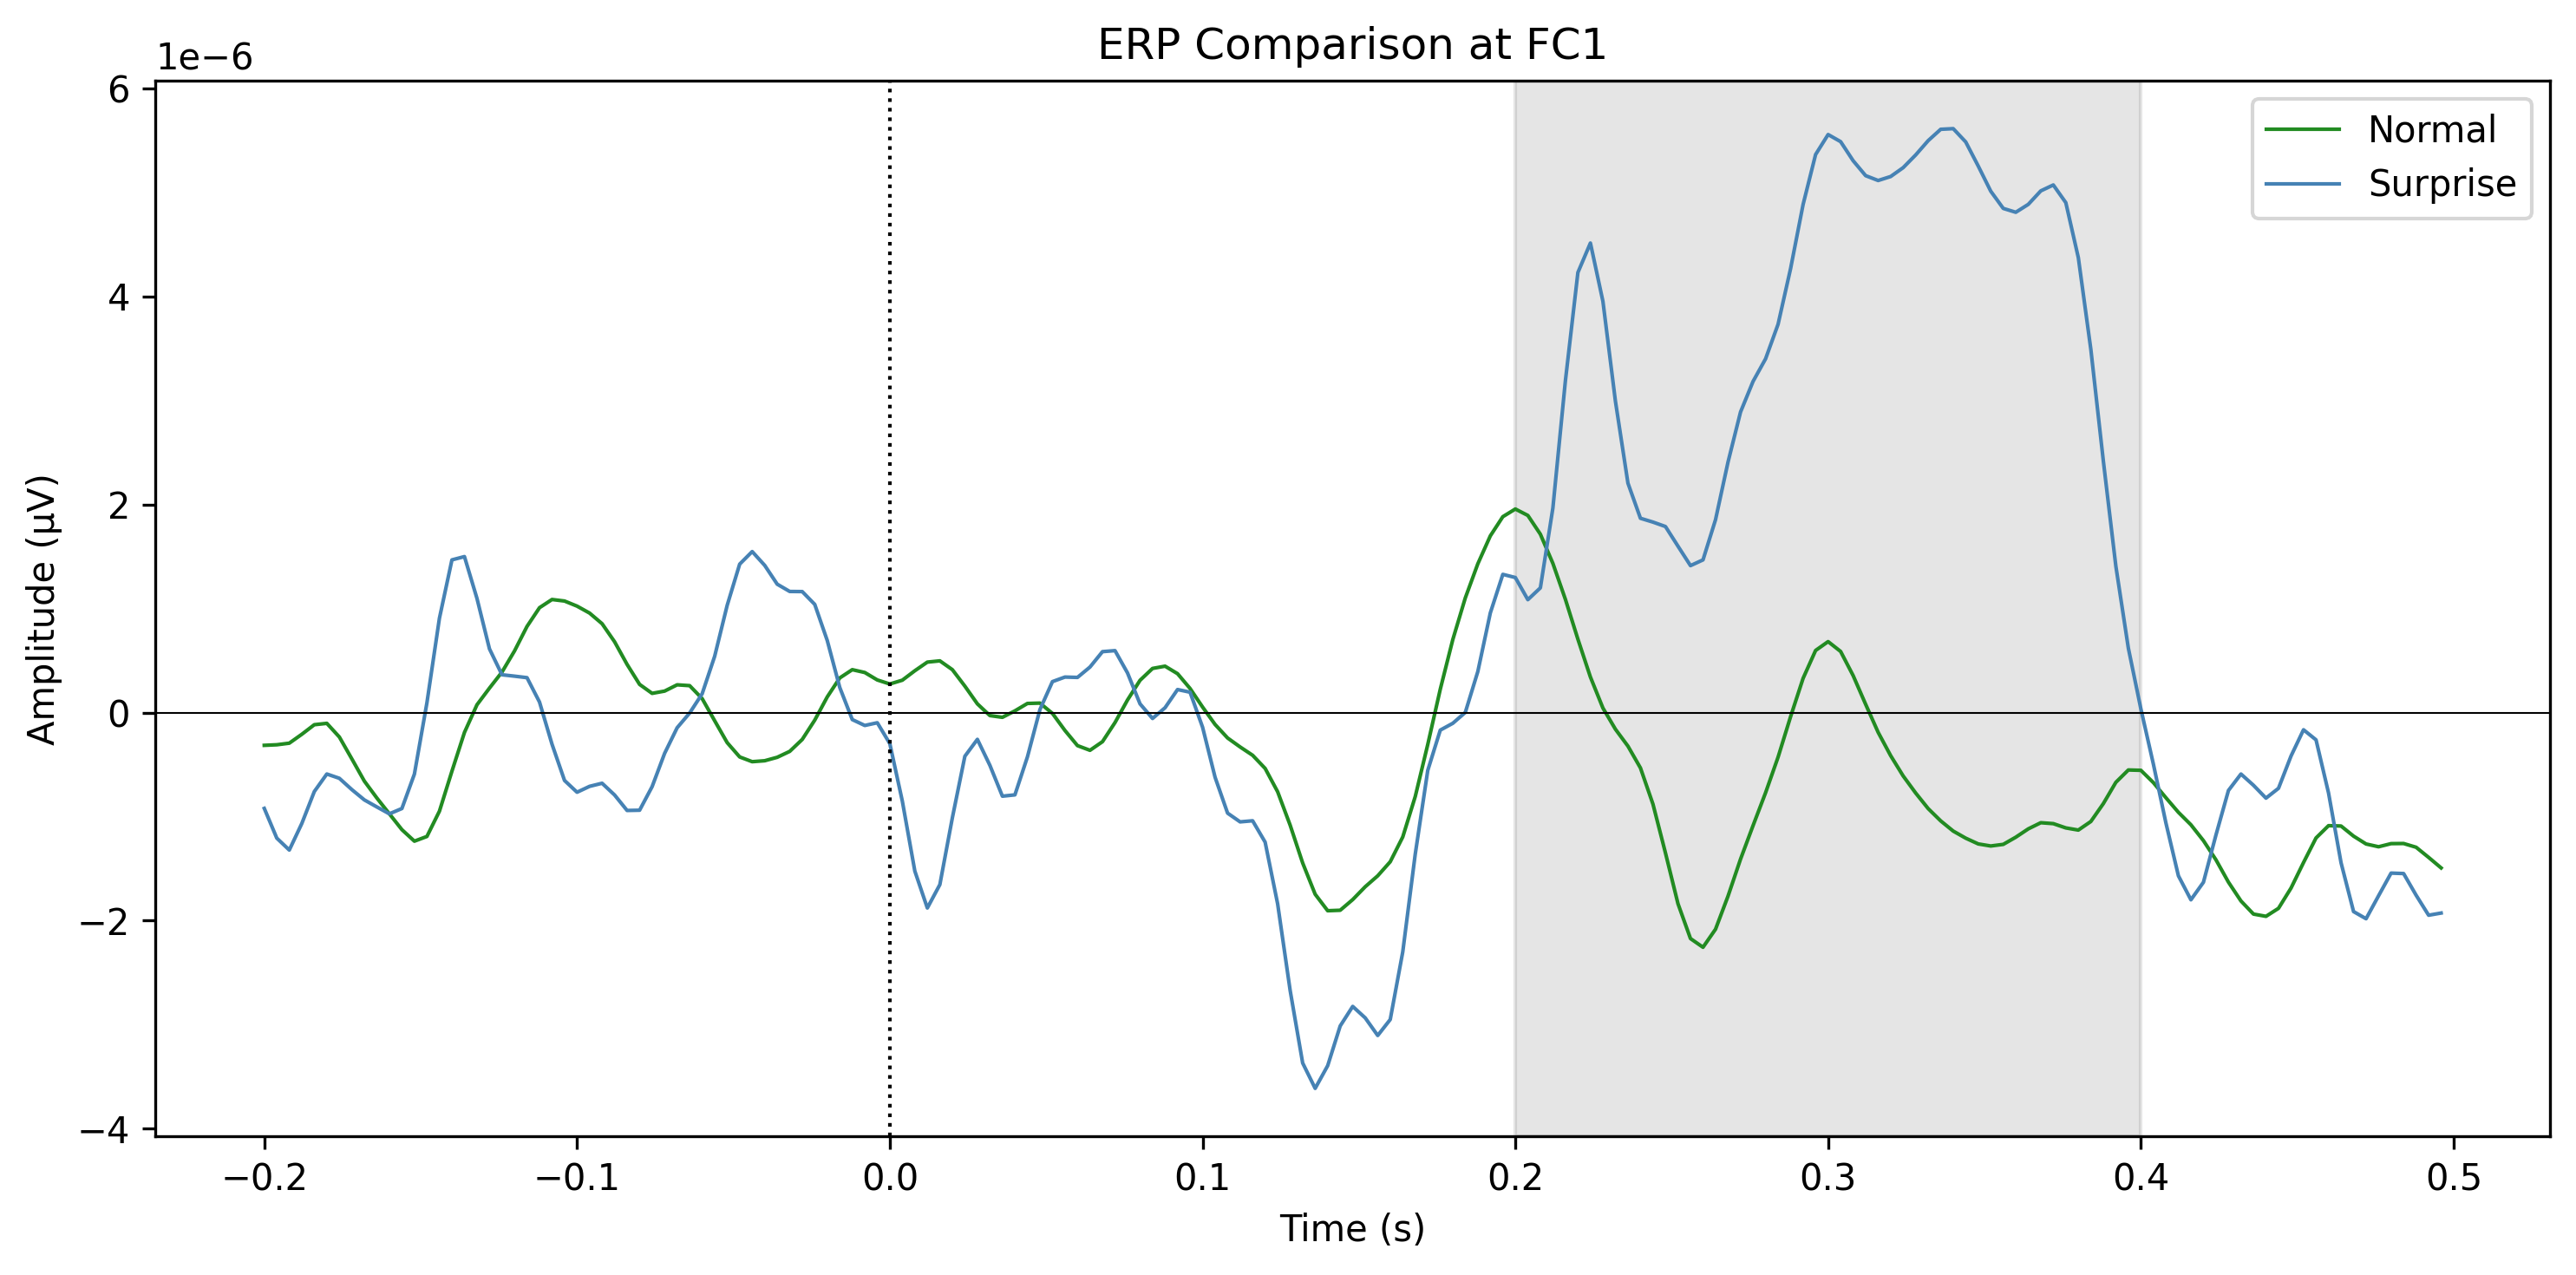

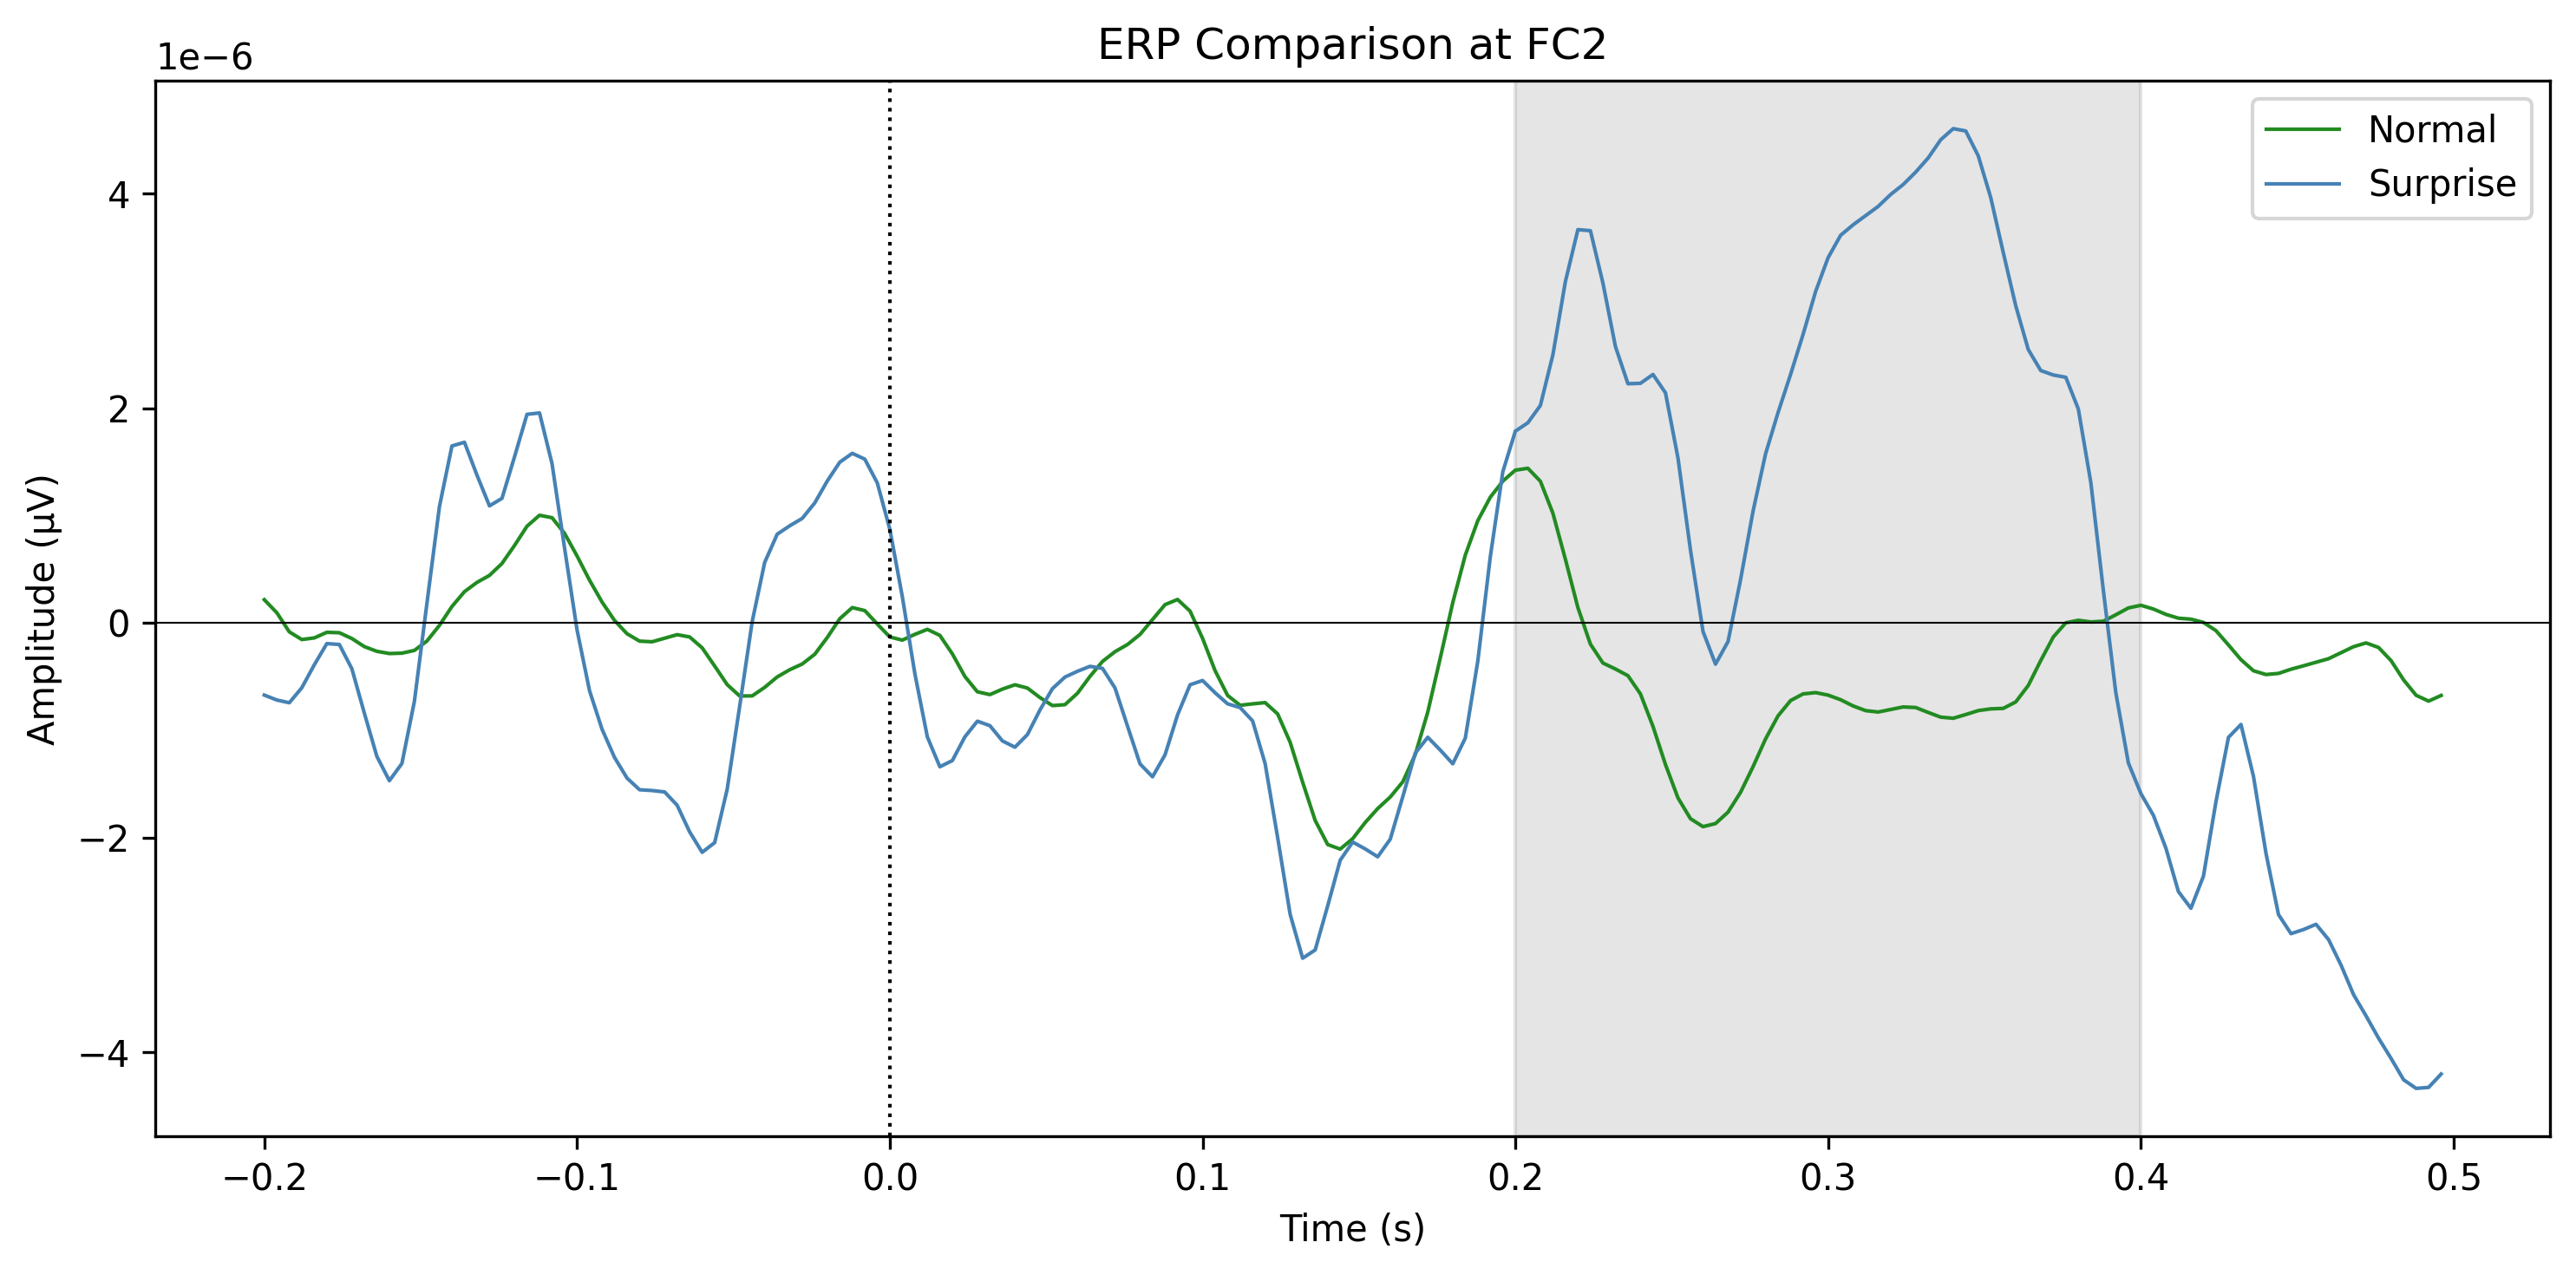

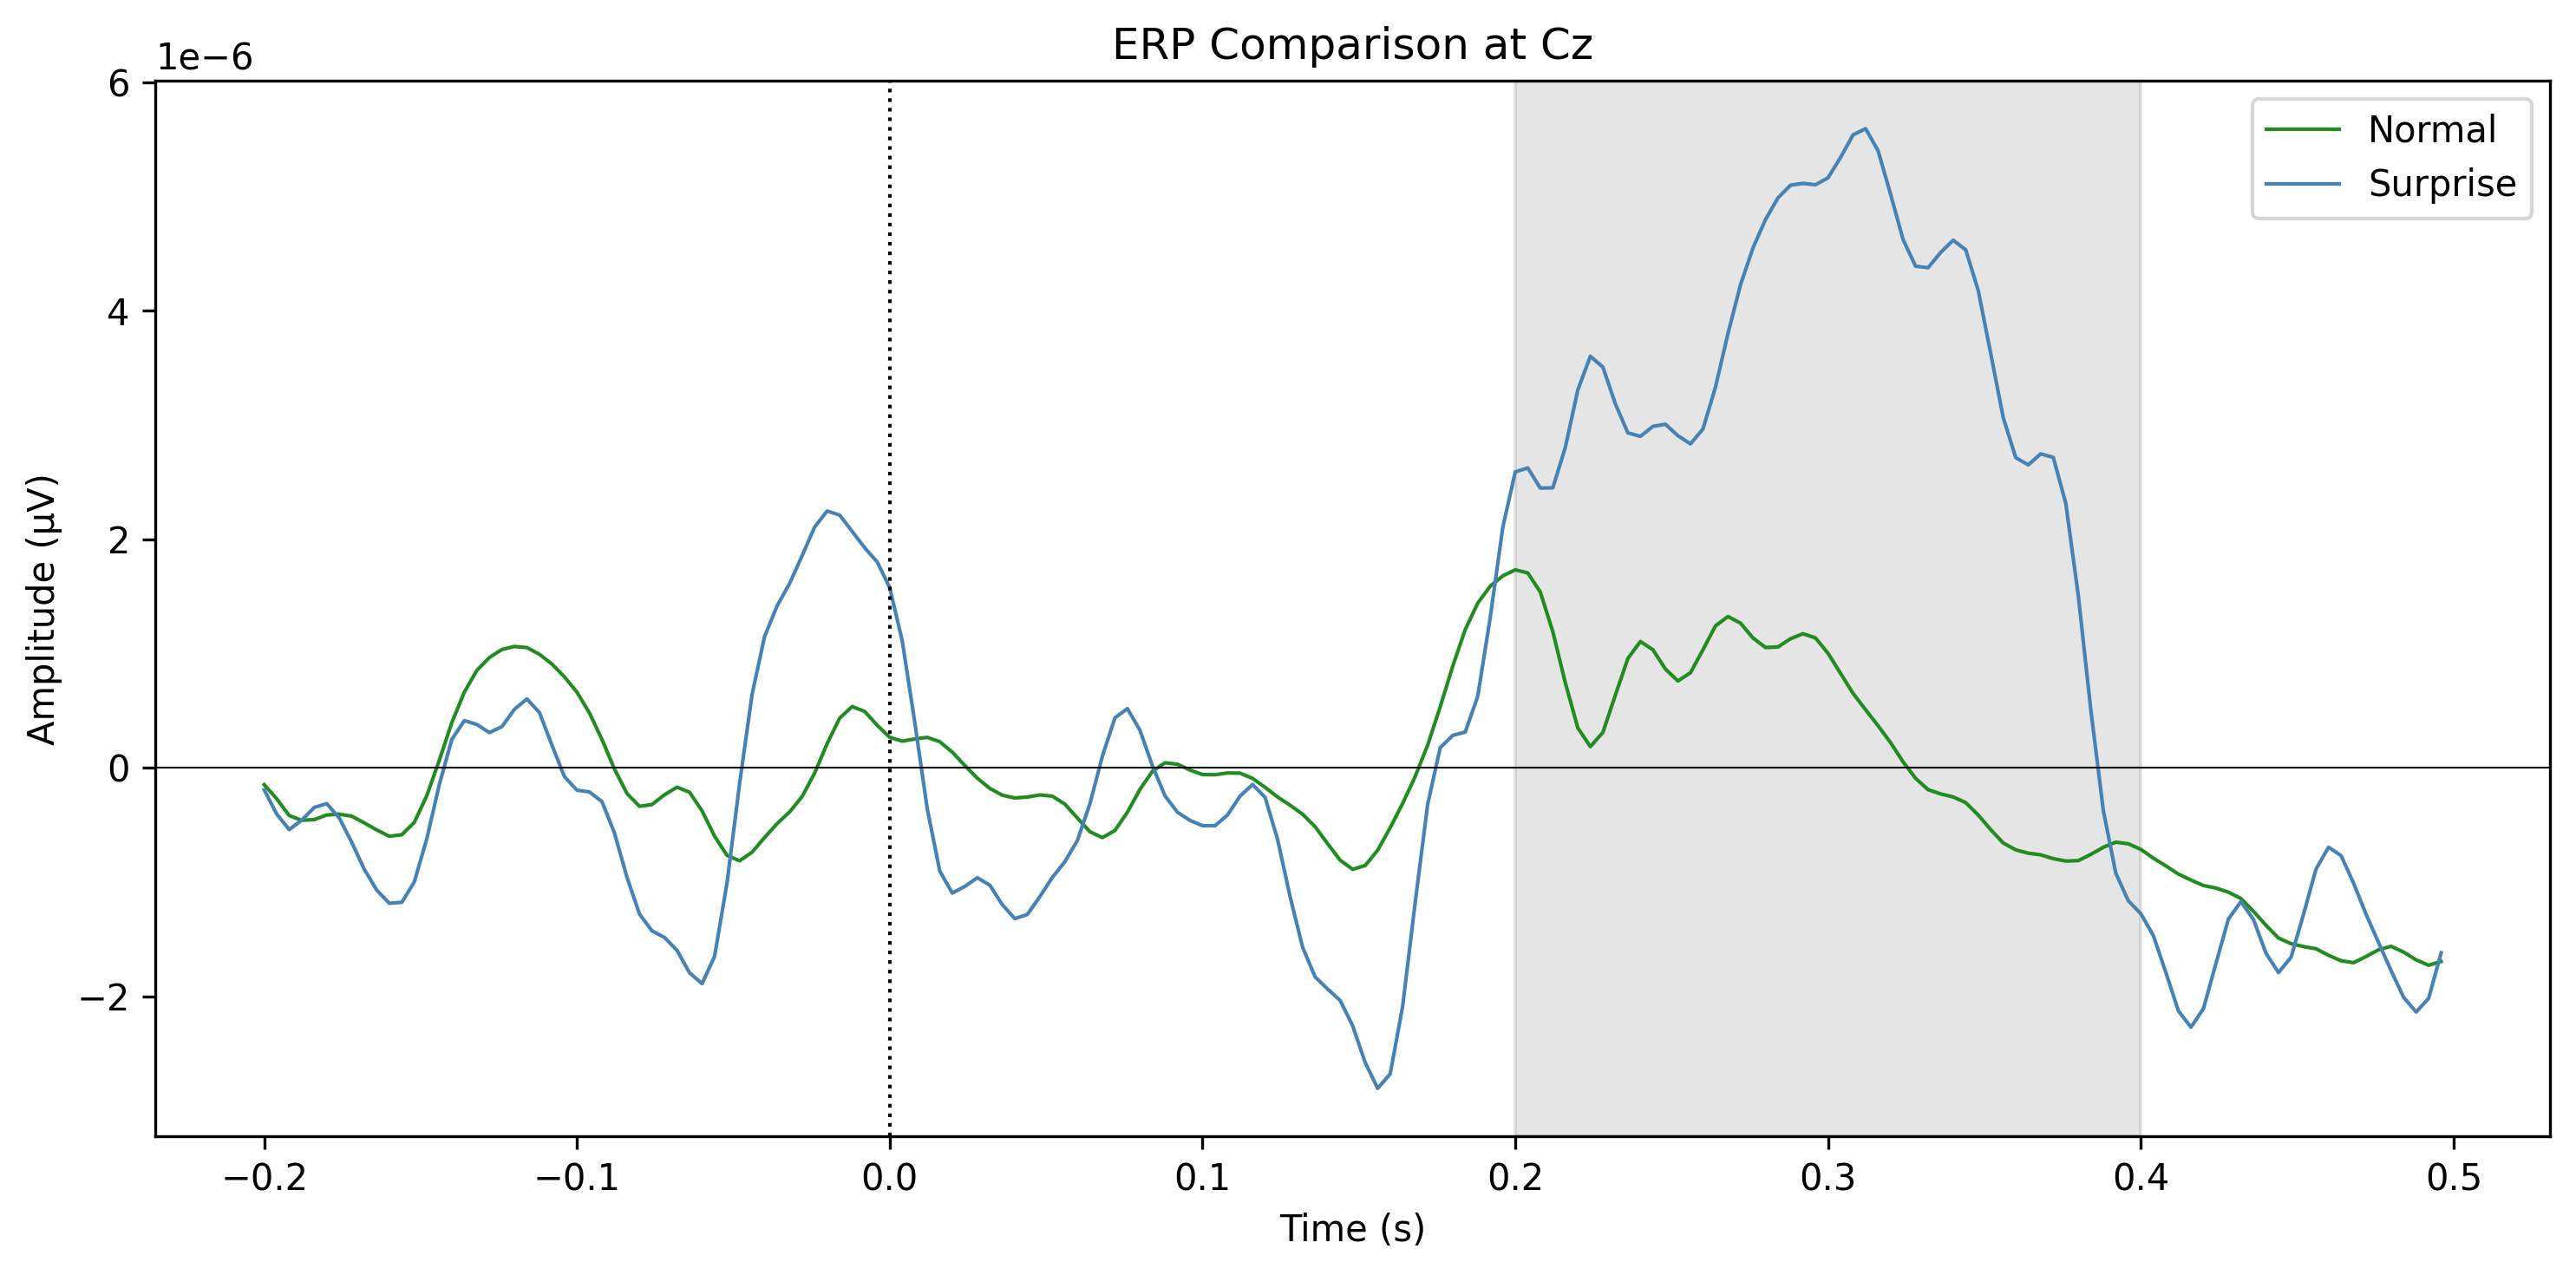

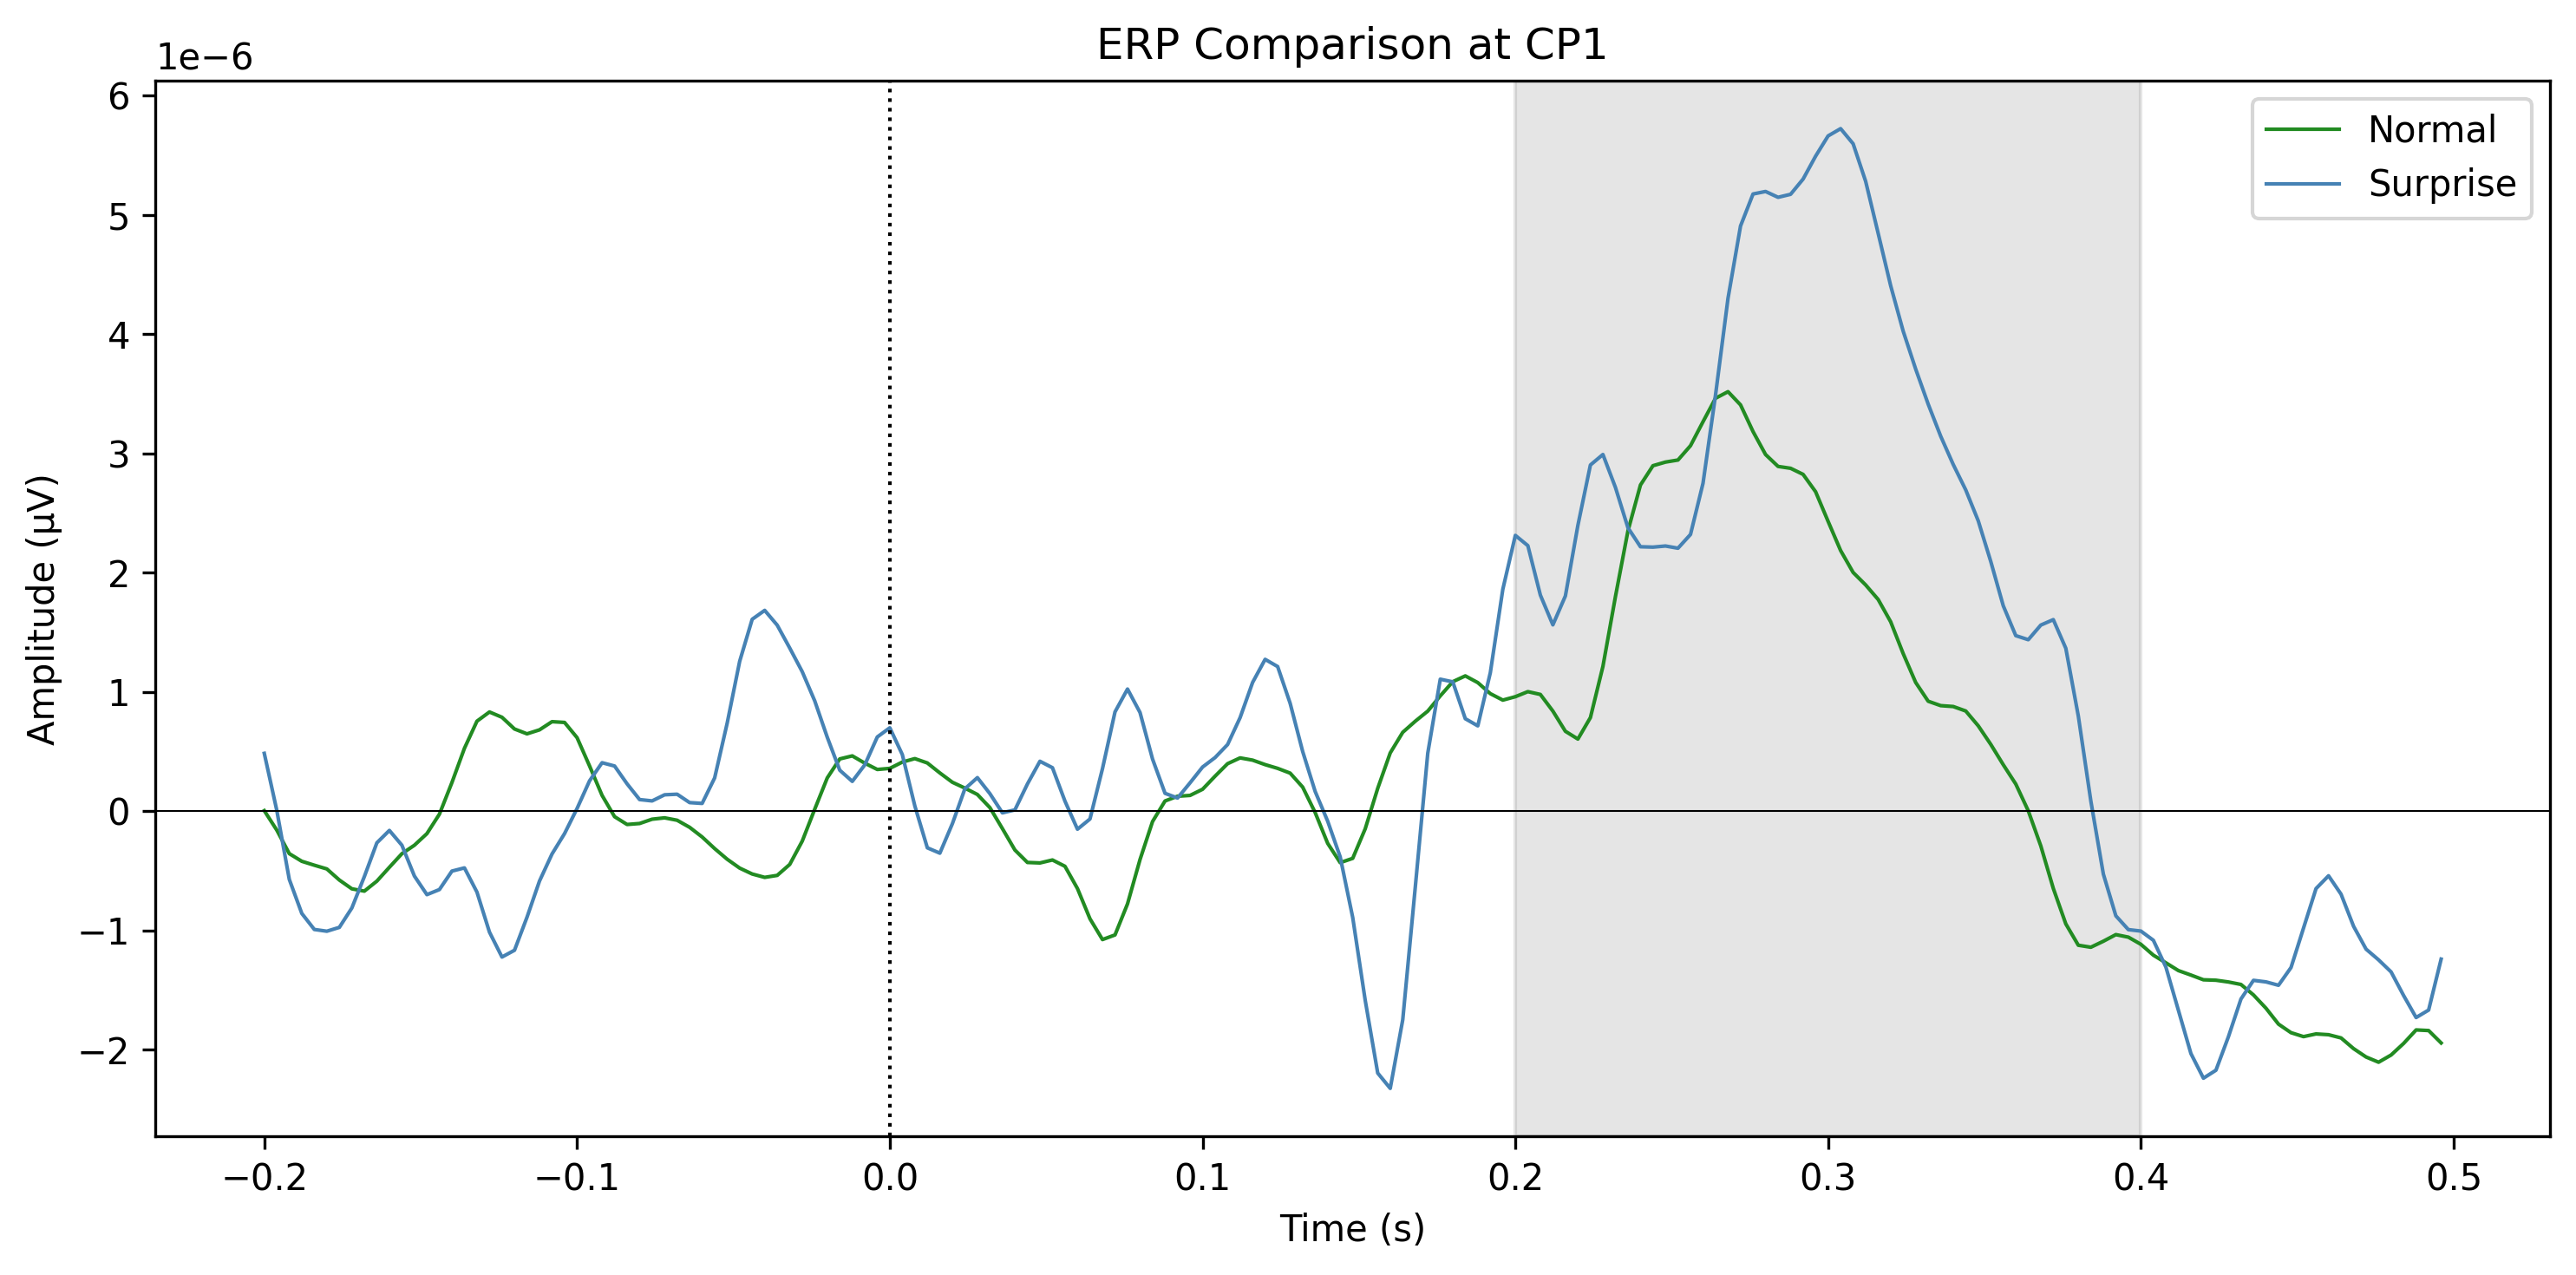

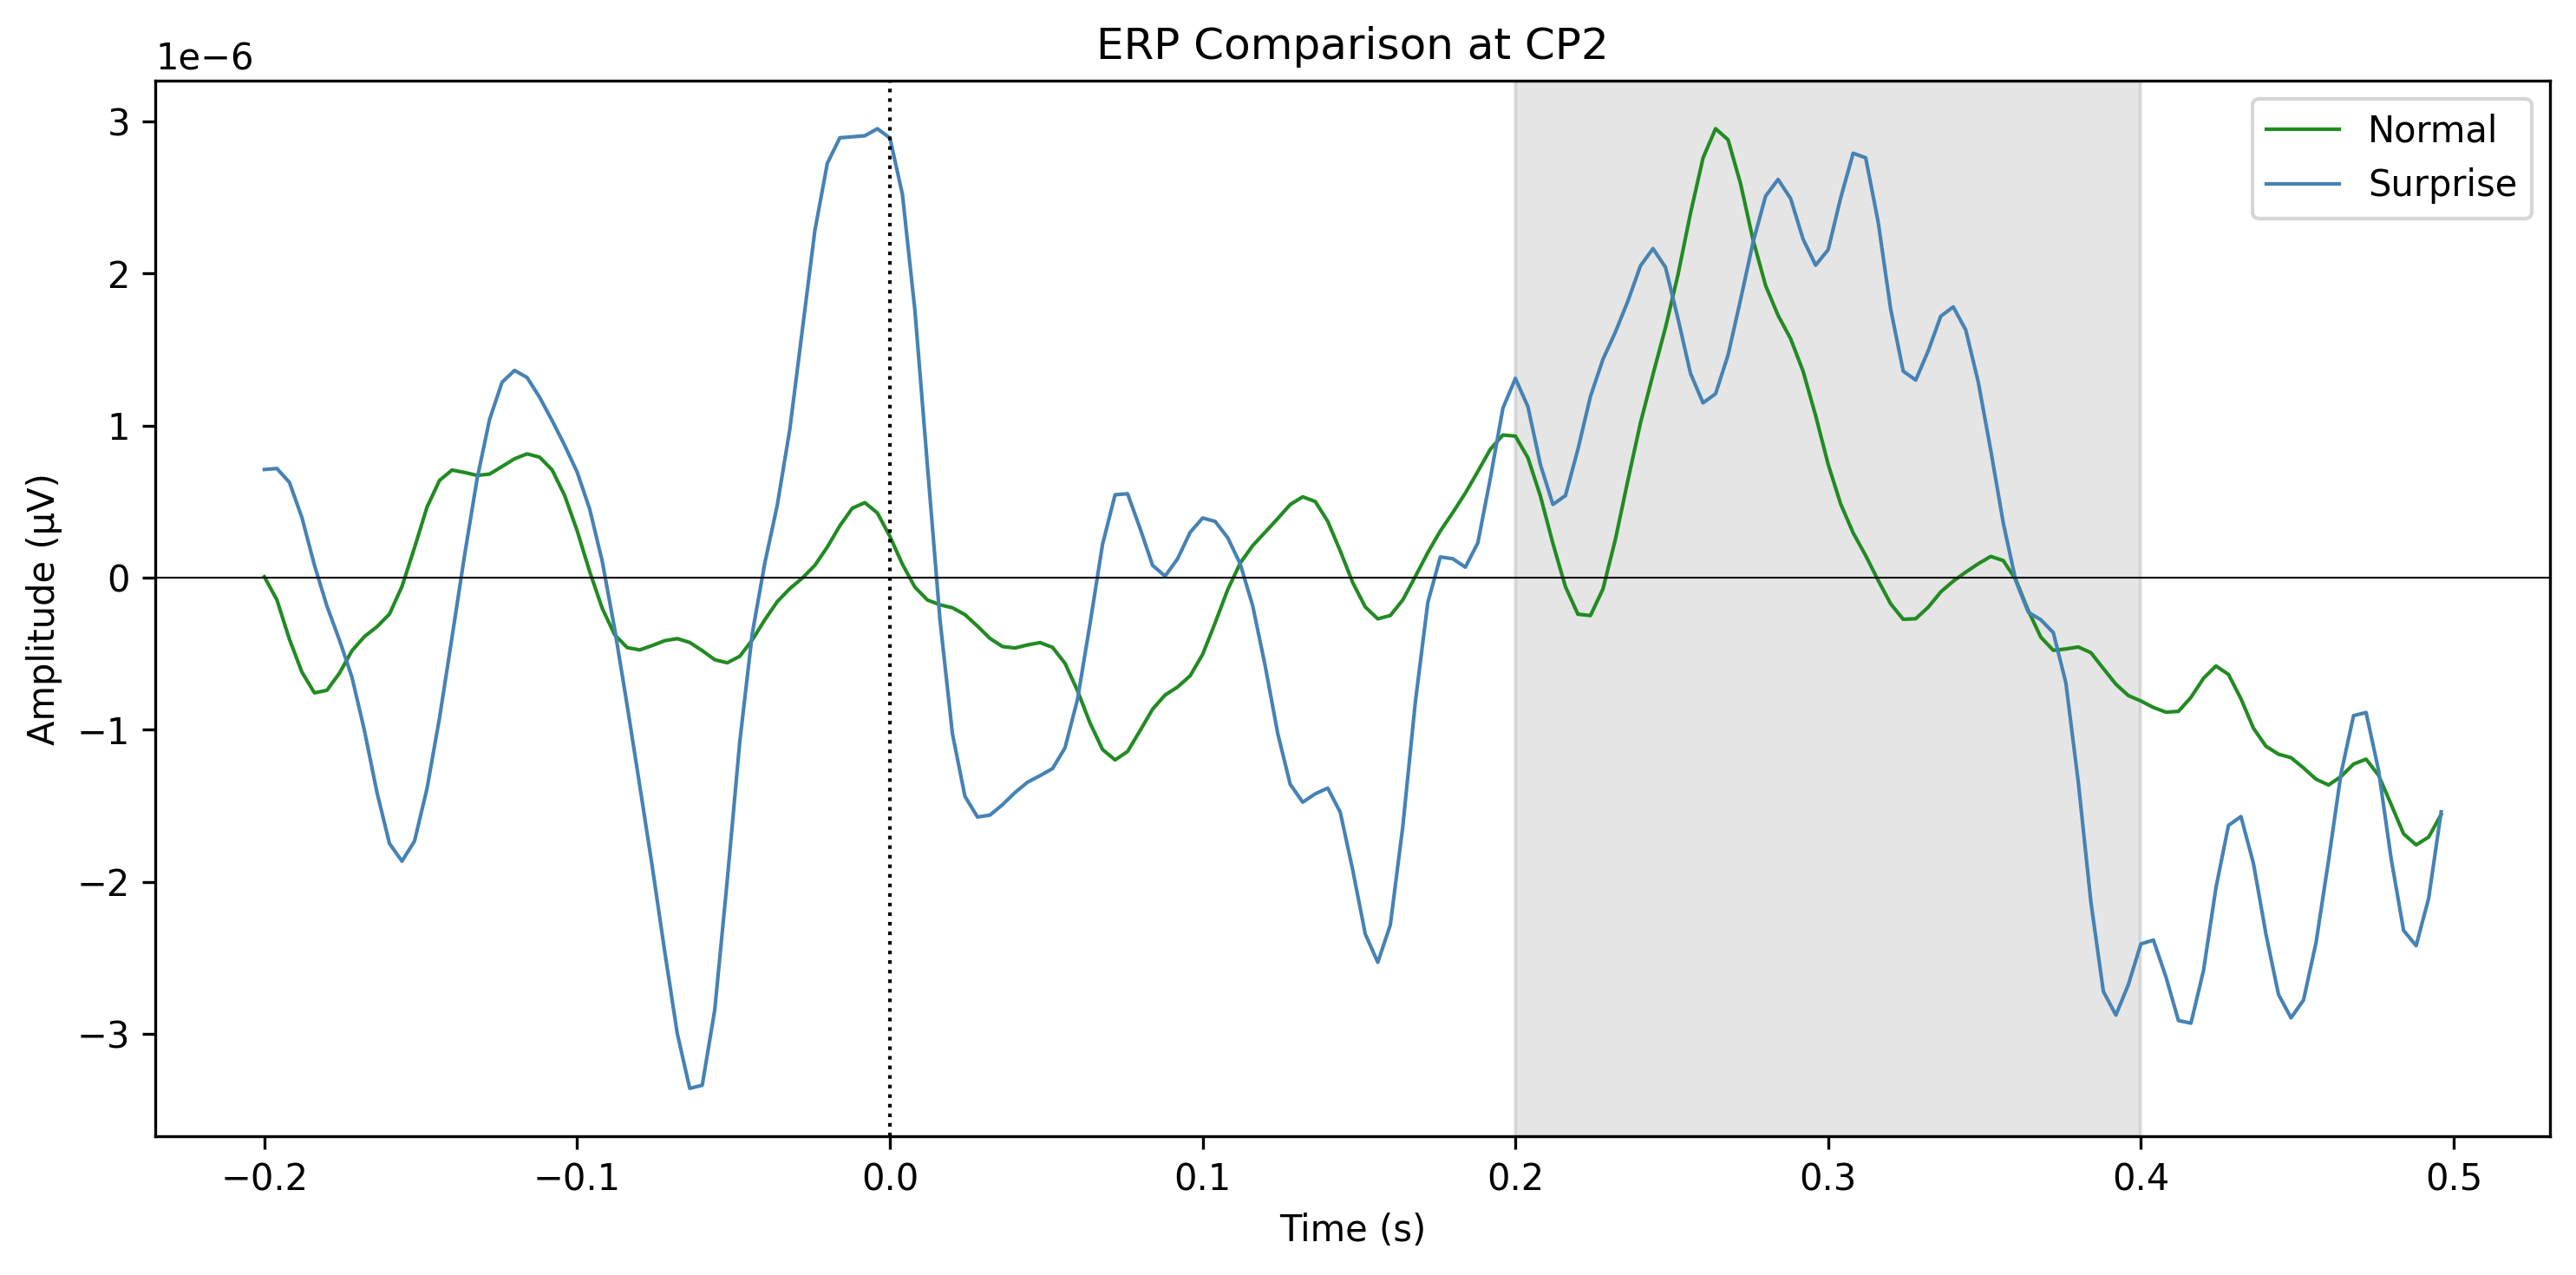

In [16]:
# Loop over each channel
for channel in picks_np:
    # Extract data for this channel (mean over trials, NOT channels)
    plot_data1 = epochs_normal.get_data(picks=[channel]).mean(axis=0).squeeze()  # Shape: (n_times,)
    plot_data2 = epochs_surprise.get_data(picks=[channel]).mean(axis=0).squeeze()
    
    # Create a new figure for this channel
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    
    # Highlight the time window
    ax.axvspan(tmin, tmax, color="grey", alpha=0.2)
    
    # Plot conditions
    ax.plot(times, plot_data1, label="Normal", color='forestgreen', linestyle="-", linewidth=1)
    ax.plot(times, plot_data2, label="Surprise", color='steelblue', linestyle="-", linewidth=1)
    
    # Mark t=0 and y=0
    ax.axvline(0, color="black", linestyle=":", linewidth=1)
    ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
    
    # Labels and title
    ax.set(
        xlabel="Time (s)", 
        ylabel="Amplitude (µV)", 
        title=f"ERP Comparison at {channel}"
    )
    ax.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

### Non averaged plot

In [66]:
# Initialize lists to store each participant's data
normal_participants = []  # Will become shape [n_participants, n_timepoints]
surprise_participants = []

for epochs in all_epochs:  # Loop over each participant's Epochs
    # Extract conditions for this participant
    epochs_normal = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]
    
    # Get data (average across trials but keep channels & time)
    data_normal = epochs_normal.get_data(picks=picks_np, tmin=None, tmax=None)  # Keep all timepoints
    data_surprise = epochs_surprise.get_data(picks=picks_np, tmin=None, tmax=None)
    
    # Average across trials and channels (but keep time)
    normal_participants.append(np.mean(data_normal, axis=(0, 1)))  # Shape: [n_timepoints]
    surprise_participants.append(np.mean(data_surprise, axis=(0, 1)))

# Convert to arrays
normal_participants = np.array(normal_participants)  # Shape: [n_participants, n_timepoints]
surprise_participants = np.array(surprise_participants)

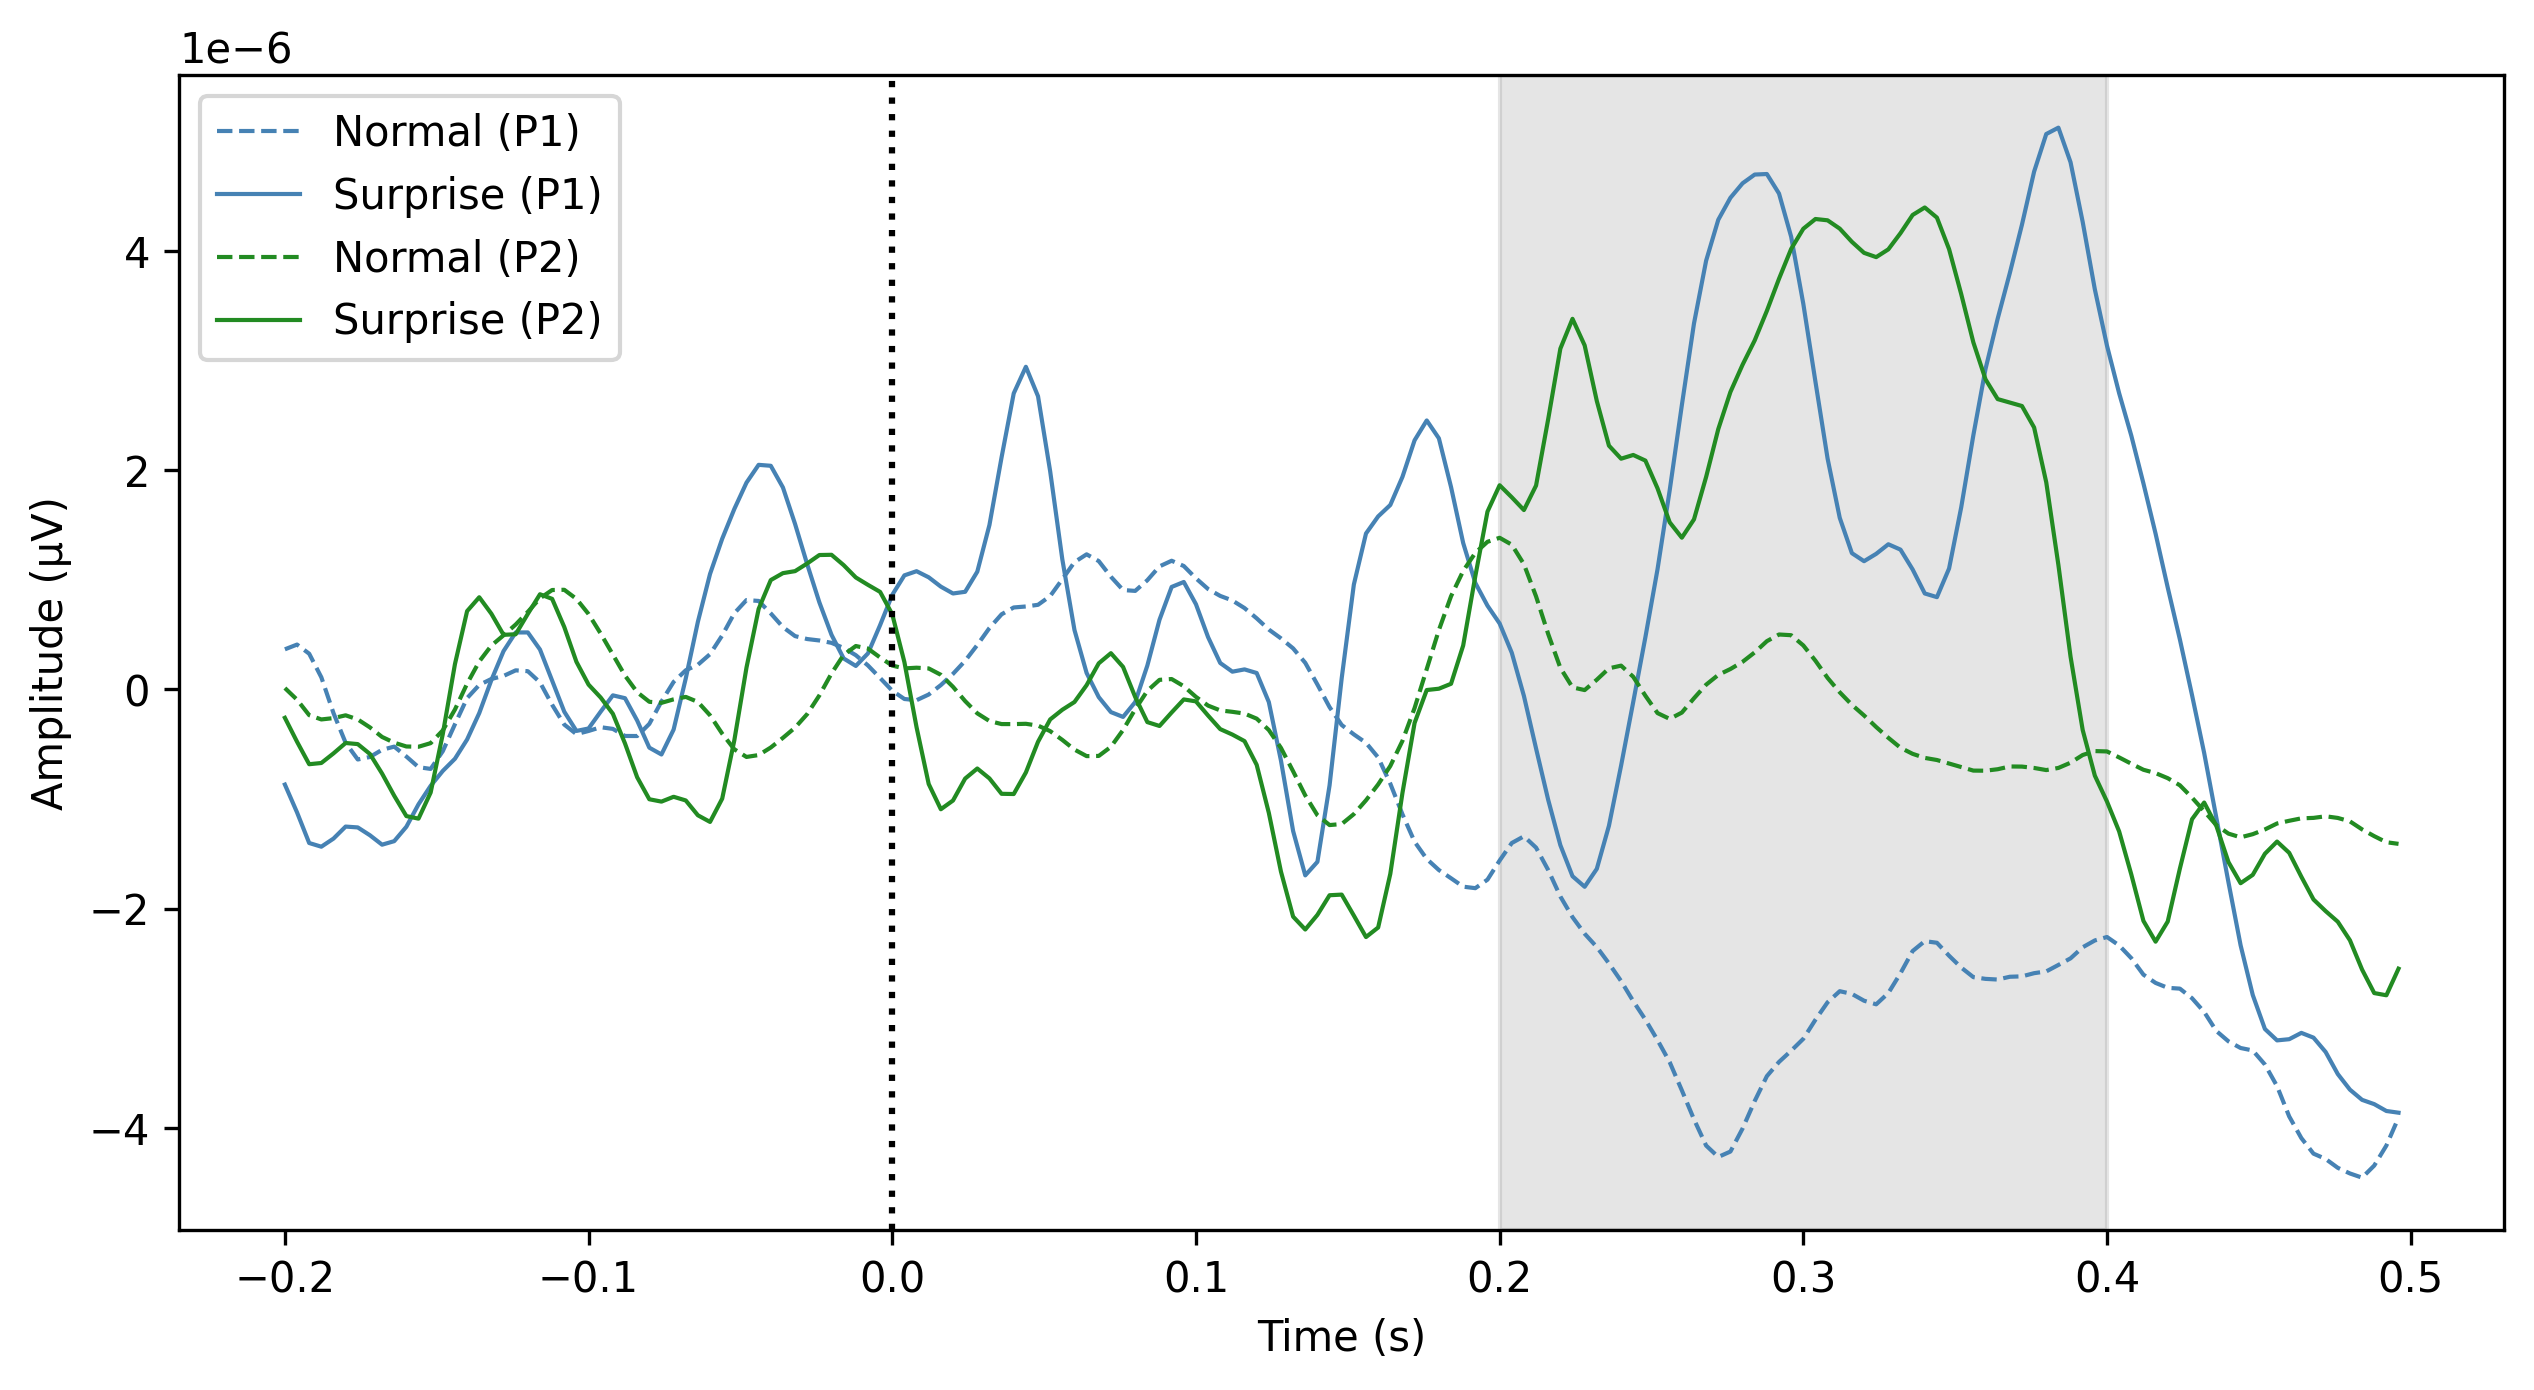

In [ ]:
colours = ["steelblue", "forestgreen"]  # Colors for each participant
times = all_epochs[0].times  # Time axis

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)  # Highlight your time window

# Plot each participant's data
for i in range(len(normal_participants)):
    color = colours[i % len(colours)]
    ax.plot(times, normal_participants[i], 
            label=f"Normal (P{i+1})", 
            color=color, linestyle="--", linewidth=1)
    ax.plot(times, surprise_participants[i], 
            label=f"Surprise (P{i+1})", 
            color=color, linestyle="-", linewidth=1)

ax.axvline(0, color="black", linestyle=":")  # Mark time-zero
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (µV)")
ax.legend()
plt.show()

## VMMN Group Level

In [7]:
tmin = 0.1
tmax = 0.25
picks_vmmn = ["Oz", "O1", "O2", "Pz", "P3", "P4"]

In [8]:
# code for group-level windowed mean
# prep data for plotting
normal = np.array([])
surprise = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_normal = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]

    # extract the data for the time window and channels of interest
    data_normal = epochs_normal.get_data(picks = picks_vmmn, tmin = tmin, tmax = tmax)
    data_surprise = epochs_surprise.get_data(picks = picks_vmmn, tmin = tmin, tmax = tmax)

    # calculate the mean over the channel and trial dimension (axis 1 and 2)
    # we keep the time dimension (axis 0) to plot the time course
    data_normal_mean = np.mean(data_normal, axis=(0, 1))
    data_surprise_mean = np.mean(data_surprise, axis=(0, 1))
    print(data_normal_mean.shape)

    # append the data to the arrays
    normal = np.concatenate((normal, data_normal_mean), axis=0)
    surprise = np.concatenate((surprise, data_surprise_mean), axis=0)

print(normal.shape)
print(surprise.shape)

# Average over trials & channels (keep time dimension)
normal_mean = np.mean(data_normal, axis=(0, 1))  # shape: [n_timepoints]
surprise_mean = np.mean(data_surprise, axis=(0, 1))

print(normal_mean.shape)
print(surprise_mean.shape)


(37,)
(37,)
(74,)
(74,)
(37,)
(37,)


### T-test

In [9]:
from scipy import stats

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(normal_mean, surprise_mean)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.6087972250499156, P-value: 0.11203707709766268


### Plot Averaged

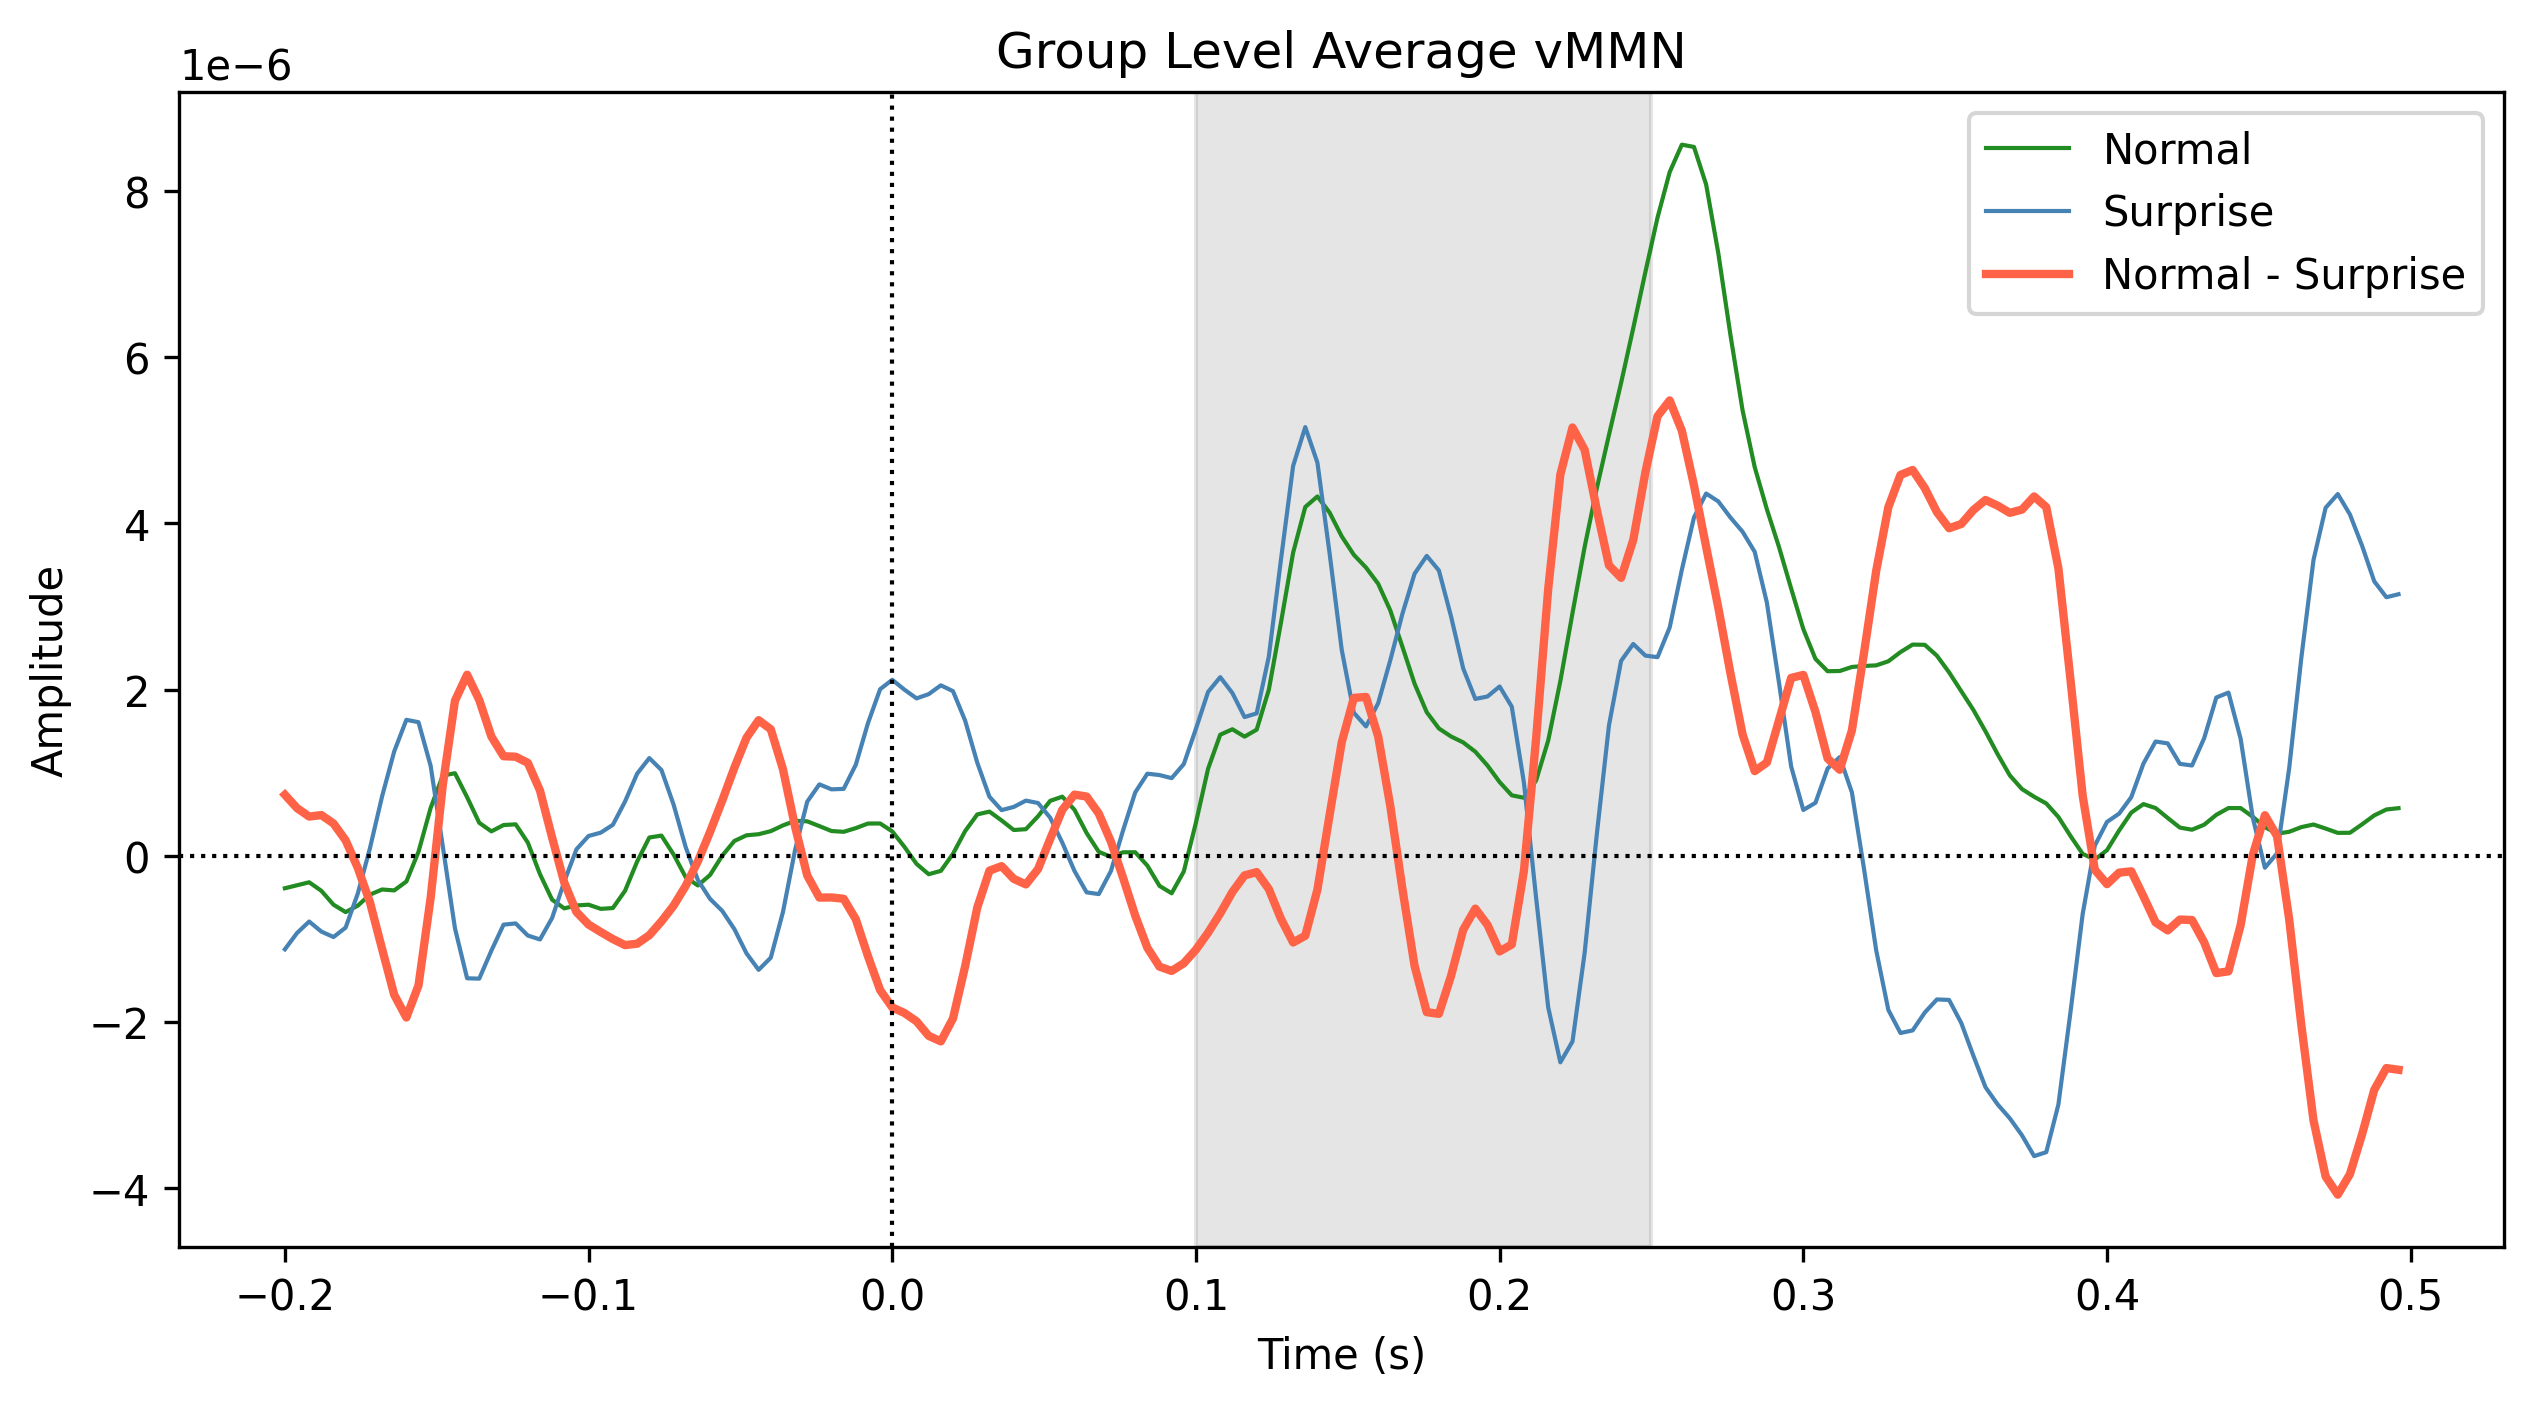

In [13]:
plot_data1 = epochs_normal.get_data(picks=picks_vmmn, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data2 = epochs_surprise.get_data(picks=picks_vmmn, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data3 = plot_data1 - plot_data2

# plotting averaged timecourses for each participant
times = epochs_normal.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, plot_data1, label="Normal", color='forestgreen', linestyle="-", linewidth=1)
ax.plot(times, plot_data2, label= "Surprise", color='steelblue', linestyle="-", linewidth=1)
ax.plot(times, plot_data3, label= "Normal - Surprise", color='tomato', linestyle="-", linewidth=2)

ax.axvline(0, color="black", linestyle=":", linewidth=1)
ax.axhline(0, color="black", linestyle=":", linewidth=1)
ax.set(xlabel="Time (s)", ylabel="Amplitude", title="Group Level Average vMMN")
ax.legend(loc = "upper right")

ax.legend()
plt.show()

# Subject-Level

## N2B-P2A complex Subject Level

In [ ]:
# load in the data
data_path = Path("./epochs/") # insert path to the preprocessed epochs of the FaceWord EEG data
filename = "epochs-epo_1.fif" # and the filename 

epochs = mne.read_epochs(data_path / filename, verbose=False, preload=True)

# only keep eeg channels
epochs.pick(["eeg"])

Now you are ready to go the `04-windowed_mean_subject_lvl.ipynb` to get inspiration for how to do a subject-level windowed mean analysis! Add code chunks below as needed!

In [7]:
# code for subject-level windowed mean
# extract the trials you are interested in
cond1 = "Normal"
cond2 = "Surprise"

epochs1 = epochs[cond1]
epochs2 = epochs[cond2] 

# chosen channels
picks = ["Fz", "FC1", "FC2", "Cz", "CP1", "CP2"]

# time window for windowed mean in seconds (NOTE THAT THIS IS DIFFERENT FROM THE TIMEWINDOW FOR THE EPOCHS)
tmin = 0.2
tmax = 0.4

# HINT 
# you can use the following to get the channel names
channel_names = epochs1.ch_names
print(channel_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


In [26]:
print(epochs_2.ch_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


In [8]:
# extract the data
data1 = epochs1.get_data(picks = picks, tmin = tmin, tmax = tmax)
data2 = epochs2.get_data(picks = picks, tmin = tmin, tmax = tmax)

data1_mean = np.mean(data1, axis=2) # averaging over the third dimension of the data (time)
print(data1_mean.shape)

data1_mean = np.mean(data1_mean, axis=1) # averaging over the second dimension of the data (channels)
print(data1_mean.shape)

# you can also do this in one line
data2_mean = np.mean(data2, axis=(1,2)) # averaging over the second and third dimension of the data (channels and time)
print(data2_mean.shape)

from scipy import stats
stats.ttest_ind(data1_mean, data2_mean)

(98, 6)
(98,)
(16,)


TtestResult(statistic=np.float64(-3.3645644983259375), pvalue=np.float64(0.0010504870643780197), df=np.float64(112.0))

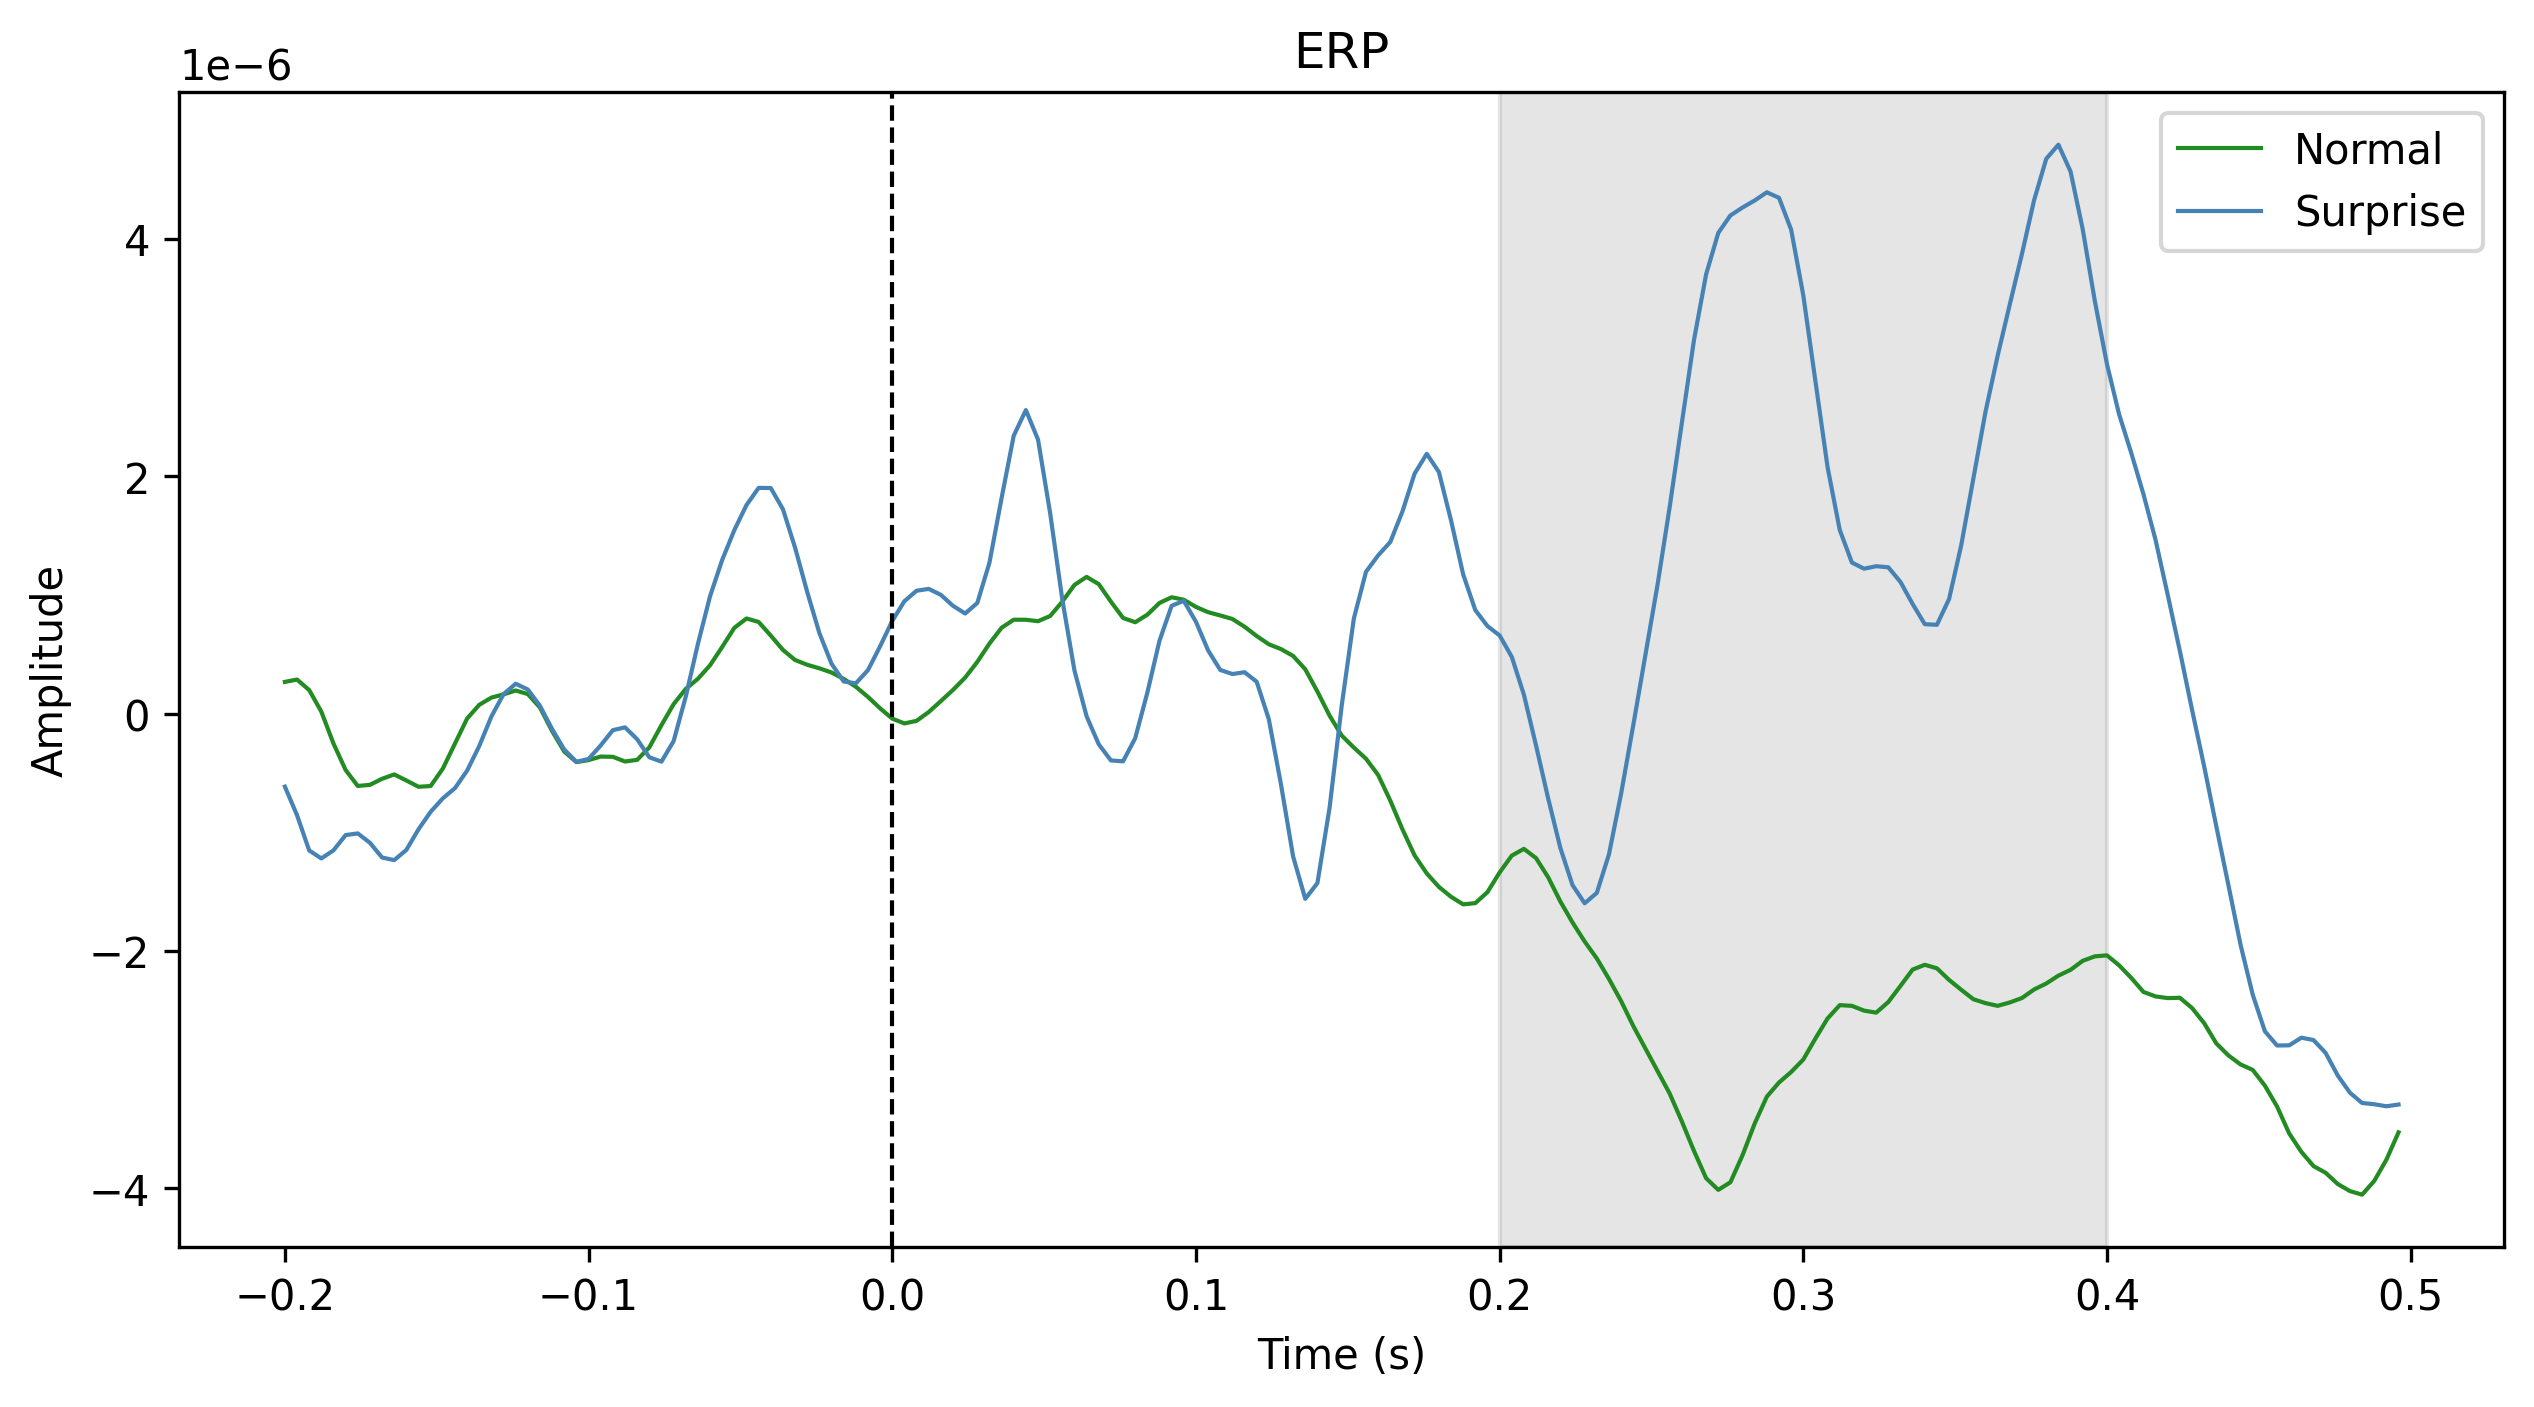

In [9]:
plot_data1 = epochs1.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data2 = epochs2.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 

times = epochs1.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# plot the time course
ax.plot(times, plot_data1.T, label="Normal", linewidth=1, color="forestgreen") #CHANGE THE LABELS SO IT MATCHES YOUR CONDITIONS
ax.plot(times, plot_data2.T, label="Surprise", linewidth=1, color="steelblue")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP")
ax.legend(loc = "upper right")

In [10]:
# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(data1_mean, data2_mean)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.3645644983259375, P-value: 0.0010504870643780197


## VMMN Subject Level

In [41]:
# code for subject-level windowed mean
# extract the trials you are interested in
cond1 = "Normal"
cond2 = "Surprise"

epochs1 = epochs[cond1]
epochs2 = epochs[cond2] 

# chosen channels
picks = ["Oz", "O1", "O2", "Pz", "P3", "P4"]

# time window for windowed mean in seconds (NOTE THAT THIS IS DIFFERENT FROM THE TIMEWINDOW FOR THE EPOCHS)
tmin = 0.1
tmax = 0.25

# HINT 
# you can use the following to get the channel names
channel_names = epochs1.ch_names
print(channel_names)

['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


In [42]:
# extract the data
data1 = epochs1.get_data(picks = picks, tmin = tmin, tmax = tmax)
data2 = epochs2.get_data(picks = picks, tmin = tmin, tmax = tmax)

data1_mean = np.mean(data1, axis=2) # averaging over the third dimension of the data (time)
print(data1_mean.shape)

data1_mean = np.mean(data1_mean, axis=1) # averaging over the second dimension of the data (channels)
print(data1_mean.shape)

# you can also do this in one line
data2_mean = np.mean(data2, axis=(1,2)) # averaging over the second and third dimension of the data (channels and time)
print(data2_mean.shape)

from scipy import stats
stats.ttest_ind(data1_mean, data2_mean)

(98, 6)
(98,)
(16,)


TtestResult(statistic=np.float64(1.0847540942341714), pvalue=np.float64(0.28036004992096863), df=np.float64(112.0))

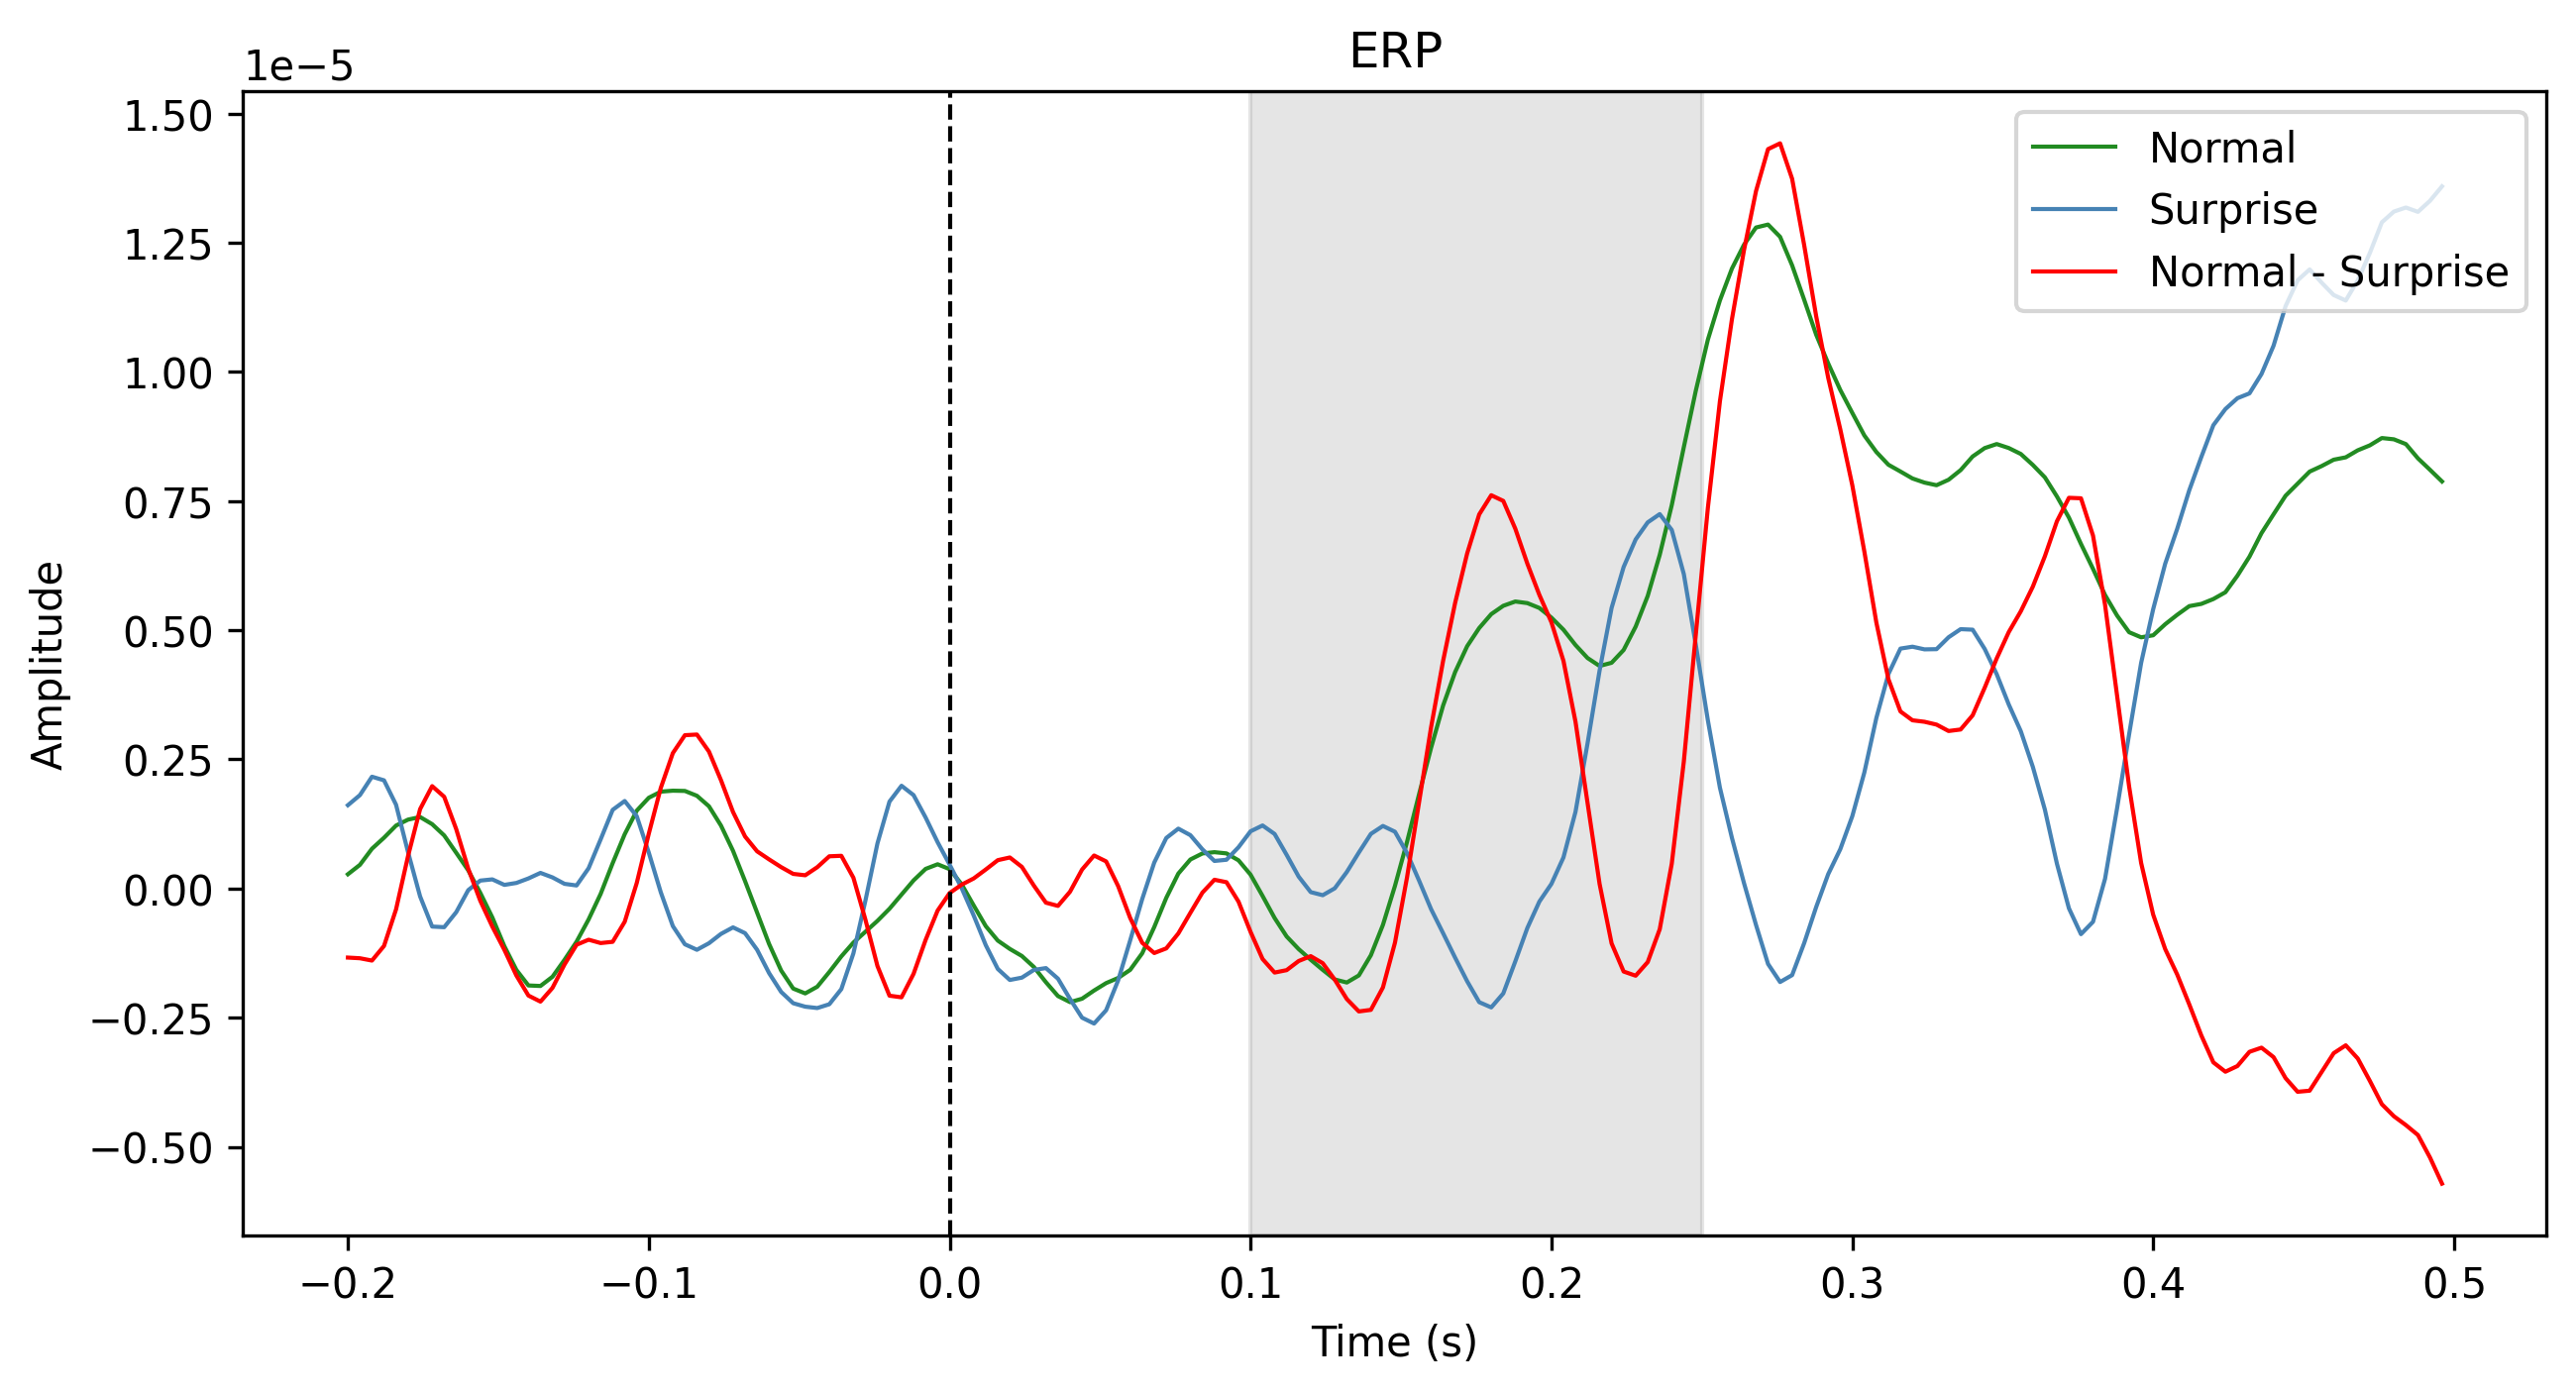

In [45]:
plot_data1 = epochs1.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data2 = epochs2.get_data(picks=picks, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data3 = plot_data1 - plot_data2

times = epochs1.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

# plot the time course
ax.plot(times, plot_data1.T, label="Normal", linewidth=1, color="forestgreen") #CHANGE THE LABELS SO IT MATCHES YOUR CONDITIONS
ax.plot(times, plot_data2.T, label="Surprise", linewidth=1, color="steelblue")
ax.plot(times, plot_data3.T, label="Normal - Surprise", linewidth=1, color="red")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP")
ax.legend(loc = "upper right")